# 
* Interested in trying to create something like a high minus low for each of the ESG factors, by industry. Run a regression. High minus low (book to market), look at high minus low ESG score.

* Need to sector normalize, if not things will be off. Return is EXPECTED to be a function of the differential between the return and the risk free rate, book to market (high minus low) and now each ESG high minus low.

* Add in the fama french factors into the regression alongside ESG


* Within one ESG, one industry
* Take the (current) highest ESG stocks and the (current) lowest ESG stocks
* See the return of each of the aforementioned over 1 month, 6 month, 12 month, 18 month periods


* e.g. Say: oil stocks, look and say: the return of the high ESGs minus the return of the low ESGs
* Believe that the result will end up in high ESG stocks - ones with high ESG risk will have a premium on the risk
* More risky companies have higher ESG Risk scores, the more risk premium they will have due to being compensated for risk

In [ ]:
## @ Denalia DO COPY
!pip install yfinance
!pip install pandas_datareader --upgrade

     |████████████████████████████████| 6.4 MB 14.7 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 109 kB 12.4 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


In [ ]:
!sudo apt-get install python3-dev libmysqlclient-dev > /dev/null
!pip install mysqlclient > /dev/null
!sudo pip3 install -U sql_magic > /dev/null
!pip install psycopg2-binary > /dev/null

In [ ]:
import pandas_datareader.data as reader
from matplotlib import pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from tqdm import tqdm
import urllib.request
import datetime as dt
import yfinance as yf
import pandas as pd
import numpy as np
import json
import time
import os

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
## @ Denalia DO NEED
conn_string = 'mysql://{user}:{password}@{host}:{port}/{db}?charset=utf8'.format(
    user='fiveguys', 
    password='PjwWc8fMC4k=', 
    host = 'jsedocc7.scrc.nyu.edu', 
    port=3306, 
    db='FiveGuys',
    encoding = 'utf-8'
)
engine = create_engine(conn_string)
connection = engine.connect()

In [ ]:
## @ Denalia DO NEED
%reload_ext sql_magic
%config SQL.conn_name = 'engine'

In [ ]:
%%read_sql
show tables;

Query started at 12:19:33 AM UTC; Query executed in 0.00 m

,Tables_in_FiveGuys
0,AV_financials
1,factors
2,fundsret_mtl
3,fundsret_mtl_final
4,histESG
5,histESG_DF
6,sp_combined
7,sp_data
8,sp_industry


In [ ]:
query = '''SELECT * FROM AV_financials LIMIT 10;'''
sp_data = pd.read_sql(query, con=engine)
sp_data

,Symbol,MarketCap,Beta,PERatio,EPS,EVToRevenue,ROE,ProfitMargin,PriceToBook,AverageStockPrice
0,ROL,15701274000,0.574,45.74,0.707,6.74,0.3420,0.1470,14.25,33.28
1,ROP,49938661000,1.064,44.25,10.540,9.23,0.1050,0.1790,4.403,412.75
2,ROST,39876794000,1.022,24.75,4.465,2.221,0.4550,0.0878,10.01,108.32
3,RCL,19236633000,2.654,None,-21.580,64.05,-0.7120,0.0000,2.974,75.45
4,SPGI,114154470000,0.985,40.53,11.600,13.98,0.7480,0.3470,61.87,351.54
5,CRM,262039550000,1.095,139.42,1.818,10.67,0.0357,0.0696,4.593,220.37
6,SBAC,39044893000,0.284,140.07,2.606,23.54,0.0000,0.1310,-,297.94
7,SLB,43467584000,2.3080000000000003,25.74,1.164,2.515,0.1310,0.0744,3.253,25.19
8,STX,23134101000,1.056,15.08,6.790,2.376,1.3350,0.1410,38.49,66.53
9,SEE,9645002000,1.29,21.12,3.037,2.457,603.9400,0.0876,75.53,44.20


## Google Drive portion for easier upload/download

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive")

In [ ]:
% cd FiveGuys
%ls

/content/drive/My Drive/FiveGuys
 AV_Financials.csv               DB_connection/           sp_combined_.csv
'Copy of DataFrame conversion'   fundsret_mtl_final.csv
'Copy of DBs Connection.ipynb'   histESG_DF.csv


# Obtains and uploads data for a list of the S&P 500 Companies from Wikipedia
## Then retrieves the data as a format of updating, this is a concept of cyclical renewal of data i.e. we will be obtaining monthly data as the months pass

In [ ]:
# Retrieves the data from Wikipedia
sp_data=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]

# Uploads the data to SQL database
sp_data.to_sql(name='sp_data',
               con=engine,
               if_exists='replace',
               index=False,
               chunksize=1000
               )

In [ ]:
## @ Denalia DO NEED
# Retrieves data from SQL database on sp_data
query = '''
        SELECT * 
        FROM sp_data;
        '''

sp_data = pd.read_sql(query, con=engine)

# Used to cycle through the data in baches
## For purposes of querying from Yahoo Finance using the yFinance API, will need to break data down into smaller chunks

In [ ]:
## @ Denalia DO NEED
# Creates a list of symbols to iterate through
symbols = list(sp_data['Symbol'])

# Used for testing purposes
test_symbols = ['MSFT', 'AAPL','NFLX', 'AMD', 'ATVI', 'GOOGL', 'AMZN', 'IPG', 'OMC']

# Breaks up symbols into chunks as to better run creation of dictionary
symbols_divided = {}
for i in range(0, len(symbols), 50):
  symbols_divided["symbol%s" %i] = symbols[i:i+50]

In [ ]:
symbols_divided

{'symbol0': ['MMM',
  'ABT',
  'ABBV',
  'ABMD',
  'ACN',
  'ATVI',
  'ADBE',
  'AMD',
  'AAP',
  'AES',
  'AFL',
  'A',
  'APD',
  'AKAM',
  'ALK',
  'ALB',
  'ARE',
  'ALGN',
  'ALLE',
  'LNT',
  'ALL',
  'GOOGL',
  'GOOG',
  'MO',
  'AMZN',
  'AMCR',
  'AEE',
  'AAL',
  'AEP',
  'AXP',
  'AIG',
  'AMT',
  'AWK',
  'AMP',
  'ABC',
  'AME',
  'AMGN',
  'APH',
  'ADI',
  'ANSS',
  'ANTM',
  'AON',
  'AOS',
  'APA',
  'AAPL',
  'AMAT',
  'APTV',
  'ADM',
  'ANET',
  'AJG'],
 'symbol100': ['CF',
  'CRL',
  'SCHW',
  'CHTR',
  'CVX',
  'CMG',
  'CB',
  'CHD',
  'CI',
  'CINF',
  'CTAS',
  'CSCO',
  'C',
  'CFG',
  'CTXS',
  'CLX',
  'CME',
  'CMS',
  'KO',
  'CTSH',
  'CL',
  'CMCSA',
  'CMA',
  'CAG',
  'COP',
  'ED',
  'STZ',
  'COO',
  'CPRT',
  'GLW',
  'CTVA',
  'COST',
  'CTRA',
  'CCI',
  'CSX',
  'CMI',
  'CVS',
  'DHI',
  'DHR',
  'DRI',
  'DVA',
  'DE',
  'DAL',
  'XRAY',
  'DVN',
  'DXCM',
  'FANG',
  'DLR',
  'DFS',
  'DISCA'],
 'symbol150': ['DISCK',
  'DISH',
  'DG',
  'DLTR

In [ ]:
histESG_DF = pd.DataFrame([])
midway_df = pd.DataFrame([])
# Switch test_symbols with symbols
for key in symbols_divided.keys():

  for symbol in tqdm(symbols_divided[key]):
    url = 'https://query2.finance.yahoo.com/v1/finance/esgChart?symbol='
    url = url + symbol
    
    connection = urllib.request.urlopen(url)

    try: 
      data = connection.read()
      data_2 = json.loads(data)

      formatdata = data_2["esgChart"]["result"][0]["symbolSeries"]

      formatdata_2 = pd.DataFrame(formatdata)
      formatdata_2["timestamp"] = pd.to_datetime(formatdata_2["timestamp"], unit="s")

      # New formatting of ESG scores starts from 12/1/2019 onwards
      # Are formatted as risk scores:
      # https://www.excelpricefeed.com/userguide/excel-formula-yahoo-finance/esg-risk-ratings
      histESG = formatdata_2.tail(22)
      
      # Interpolate scores using nearest neighbor algorithm applied rowise
      # This is due to the scores only changing once ever 2 or 3 months
      # Scores are given in the format of score(Risk)
      histESG = histESG.interpolate(method='nearest', axis=0)

      # Filters out companies with old scores that are greater than 40
      print(f'Testing for legacy ratings and NaN values in {symbol}')
      if not histESG.tail(1)[(histESG.tail(1)['socialScore'] > 40)].empty and not histESG.tail(1)[(histESG.tail(1)['governanceScore'] > 40)].empty and not histESG.tail(1)[(histESG.tail(1)['enviornmentScore'] > 40)].empty:
        print(f'Legacy score found for {symbol}, dropping dataframe')
        continue # Goes to next company if any last entry of histESG is empty

      # Or companies with NaN ESG scores
      if histESG.isnull().values.any():
        print(f'NaN value found for {symbol}, dropping dataframe')
        continue

      # Creates a variable representing industry of companies
      peerGroup = data_2['esgChart']['result'][0]['peerGroup']

      # Creates appendages of the main dataframe
      to_midway = formatdata_2.tail(1) # Midway dataframe will only use the most resent row of ESG data
      to_midway['Symbol'] = symbol # Sets the symbol of the current company to the symbol of the company
      to_midway['Industry'] = peerGroup # Sets the industry of the current company to it's industry

      midway_df = pd.concat([midway_df, to_midway]).drop(columns='timestamp')
      # Creates a dictionary of ESG scores alongside their respective company
      # Iniates such that his dataframe has columns corresponding to its specific symbol
      
      histESG['Symbol'] = symbol
      histESG_DF = pd.concat([histESG_DF, histESG], axis=0)

      print(histESG_DF)
    except:

      print(f'Exception found for {symbol}')
      continue

  print(key)
  # Yahoo Finance API refusing connection, requires time.sleep
  time.sleep(60)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 1/50 [00:00<00:07,  6.50it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Testing for legacy ratings and NaN values in MMM
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
68 2020-05-01     33.54             8.39             12.60        12.55    MMM
69 2020-06-01     34.75             8.07             12.79        13.89    MMM
70 2020-07-01     34.75             8.07             12.79        13.89    MMM
71 2020-08-01     34.75             8.07             12.79        13.89    MMM
72 2020-09-01     34.75             8.07             12.79        13.89    MMM
73 2020-10-01     34.86             8.07             12.79        14.00    MMM
74 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  6%|▌         | 3/50 [00:00<00:06,  7.72it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Testing for legacy ratings and NaN values in ABBV
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     29.07            11.33              0.65        17.09   ABBV
81 2021-06-01     29.07            11.33              0.65        17.09   ABBV
82 2021-07-01     29.07            11.33              0.65        17.09   ABBV
83 2021-08-01     27.38            10.10              0.65        16.64   ABBV
84 2021-09-01     27.38            10.10              0.65        16.64   ABBV

[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 12%|█▏        | 6/50 [00:00<00:04,  8.95it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Testing for legacy ratings and NaN values in ATVI
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
76 2021-01-01     17.04             6.22              0.15        10.66   ATVI
77 2021-02-01     17.04             6.22              0.15        10.66   ATVI
78 2021-03-01     17.04             6.22              0.15        10.66   ATVI
79 2021-04-01     17.04             6.22              0.15        10.66   ATVI
80 2021-05-01     16.15             6.15              0.15         9.84   ATVI

[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 18%|█▊        | 9/50 [00:01<00:04,  9.38it/s]

Exception found for AMD
Testing for legacy ratings and NaN values in AAP
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23              12.6        12.70    MMM
64 2020-01-01     34.53             9.23              12.6        12.70    MMM
65 2020-02-01     34.53             9.23              12.6        12.70    MMM
66 2020-03-01     33.54             8.39              12.6        12.55    MMM
67 2020-04-01     33.54             8.39              12.6        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     12.10             3.33               0.1         8.67    AAP
81 2021-06-01     12.10             3.33               0.1         8.67    AAP
82 2021-07-01     12.10             3.33               0.1         8.67    AAP
83 2021-08-01     12.58             3.33               0.1         9.14    AAP
84 2021-09-01     12.58             3.33               0.1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 20%|██        | 10/50 [00:01<00:04,  9.19it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     34.94             5.84             20.79         8.31    AES
81 2021-06-01     34.94             5.84             20.79         8.31    AES
82 2021-07-01     34.94             5.84             20.79         8.31    AES
83 2021-08-01     35.05             5.95             20.79         8.31    AES
84 2021-09-01     35.05             5.95             20.79         8.31    AES

[176 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 24%|██▍       | 12/50 [00:01<00:04,  8.87it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in A
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     16.57             6.26              0.87         9.44      A
81 2021-06-01     16.57             6.26              0.87         9.44      A
82 2021-07-01     16.57             6.26              0.87         9.44      A
83 2021-08-01     16.57             6.26              0.87         9.44      A
84 2021-09-01     16.57             6.26              0.87         9.44      A

[220

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 28%|██▊       | 14/50 [00:01<00:04,  8.78it/s]

Testing for legacy ratings and NaN values in AKAM
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     21.34             7.63              1.91        11.80   AKAM
81 2021-06-01     21.34             7.63              1.91        11.80   AKAM
82 2021-07-01     21.34             7.63              1.91        11.80   AKAM
83 2021-08-01     20.16             7.88              1.93        10.35   AKAM
84 2021-09-01     20.16             7.88              1.93        10.35   AKAM

[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 32%|███▏      | 16/50 [00:01<00:03,  9.27it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     36.74             8.74             19.09         8.91    ALB
81 2021-06-01     36.74             8.74             19.09         8.91    ALB
82 2021-07-01     36.74             8.74             19.09         8.91    ALB
83 2021-08-01     37.21             8.90             19.09         9.21    ALB
84 2021-09-01     37.21             8.90             19.09         9.21    ALB

[286 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 38%|███▊      | 19/50 [00:02<00:03,  9.52it/s]

Exception found for ALGN
Testing for legacy ratings and NaN values in ALLE
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
79 2021-05-01     23.11             6.55             12.34         4.23   ALLE
80 2021-06-01     23.11             6.55             12.34         4.23   ALLE
81 2021-07-01     23.11             6.55             12.34         4.23   ALLE
82 2021-08-01     23.15             6.59             12.34         4.23   ALLE
83 2021-09-01     23.15             6.59             12.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 40%|████      | 20/50 [00:02<00:03,  8.78it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in LNT
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     27.99             6.30             14.30         7.38    LNT
81 2021-06-01     27.99             6.30             14.30         7.38    LNT
82 2021-07-01     27.99             6.30             14.30         7.38    LNT
83 2021-08-01     22.36             6.67             10.04         5.65    LNT
84 2021-09-01     22.36             6.67             10.04         5.65    LNT

[3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 46%|████▌     | 23/50 [00:02<00:03,  8.56it/s]

Testing for legacy ratings and NaN values in GOOGL
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     22.29            11.90              0.48         9.91  GOOGL
81 2021-06-01     22.29            11.90              0.48         9.91  GOOGL
82 2021-07-01     22.29            11.90              0.48         9.91  GOOGL
83 2021-08-01     22.89            11.62              0.48        10.79  GOOGL
84 2021-09-01     22.89            11.62              0.48        10.79  GOOGL



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 48%|████▊     | 24/50 [00:02<00:02,  8.74it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in MO
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     25.27             6.54              5.95        12.78     MO
81 2021-06-01     25.27             6.54              5.95        12.78     MO
82 2021-07-01     25.27             6.54              5.95        12.78     MO
83 2021-08-01     24.40             6.76              4.66        12.98     MO
84 2021-09-01     24.40             6.76              4.66        12.98     MO

[41

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 54%|█████▍    | 27/50 [00:03<00:02,  9.56it/s]

Exception found for AMCR
Testing for legacy ratings and NaN values in AEE
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     33.63             5.95             15.48        12.19    AEE
81 2021-06-01     33.63             5.95             15.48        12.19    AEE
82 2021-07-01     33.63             5.95             15.48        12.19    AEE
83 2021-08-01     29.14             5.55             15.73         7.86    AEE
84 2021-09-01     29.14             5.55             15.7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 56%|█████▌    | 28/50 [00:03<00:02,  9.30it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     28.03             5.58              9.80        12.65    AAL
81 2021-06-01     28.03             5.58              9.80        12.65    AAL
82 2021-07-01     28.03             5.58              9.80        12.65    AAL
83 2021-08-01     29.81             5.40             11.76        12.65    AAL
84 2021-09-01     29.81             5.40             11.76        12.65    AAL

[484 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 60%|██████    | 30/50 [00:03<00:02,  9.06it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     18.94             9.08              0.05         9.81    AXP
81 2021-06-01     18.94             9.08              0.05         9.81    AXP
82 2021-07-01     18.94             9.08              0.05         9.81    AXP
83 2021-08-01     19.81             8.51              0.05        11.24    AXP
84 2021-09-01     19.81             8.51              0.05        11.24    AXP

[528 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 64%|██████▍   | 32/50 [00:03<00:02,  8.91it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     12.33             4.81              3.73         3.78    AMT
81 2021-06-01     12.33             4.81              3.73         3.78    AMT
82 2021-07-01     12.33             4.81              3.73         3.78    AMT
83 2021-08-01     12.33             4.81              3.73         3.78    AMT
84 2021-09-01     12.33             4.81              3.73         3.78    AMT

[572 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 68%|██████▊   | 34/50 [00:03<00:01,  8.95it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23              12.6        12.70    MMM
64 2020-01-01     34.53             9.23              12.6        12.70    MMM
65 2020-02-01     34.53             9.23              12.6        12.70    MMM
66 2020-03-01     33.54             8.39              12.6        12.55    MMM
67 2020-04-01     33.54             8.39              12.6        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     25.80            12.84               2.3        10.66    AMP
81 2021-06-01     25.80            12.84               2.3        10.66    AMP
82 2021-07-01     25.80            12.84               2.3        10.66    AMP
83 2021-08-01     22.63            12.29               2.8         7.54    AMP
84 2021-09-01     22.63            12.29               2.8         7.54    AMP

[616 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 72%|███████▏  | 36/50 [00:04<00:01,  8.97it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     25.98             7.71              8.32         9.95    AME
81 2021-06-01     25.98             7.71              8.32         9.95    AME
82 2021-07-01     25.98             7.71              8.32         9.95    AME
83 2021-08-01     25.95             7.69              8.32         9.95    AME
84 2021-09-01     25.95             7.69              8.32         9.95    AME

[660 rows x 6 columns]
Testing for legacy ratings a

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 76%|███████▌  | 38/50 [00:04<00:01,  8.74it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in APH
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     23.80             7.70             10.08         6.02    APH
81 2021-06-01     23.80             7.70             10.08         6.02    APH
82 2021-07-01     23.80             7.70             10.08         6.02    APH
83 2021-08-01     21.60             8.04              8.04         5.52    APH
84 2021-09-01     21.60             8.04              8.04         5.52    APH

[7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 80%|████████  | 40/50 [00:04<00:01,  8.68it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in ANSS
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     14.94             4.84              1.13         8.96   ANSS
81 2021-06-01     14.94             4.84              1.13         8.96   ANSS
82 2021-07-01     14.94             4.84              1.13         8.96   ANSS
83 2021-08-01     15.12             5.02              1.13         8.96   ANSS
84 2021-09-01     15.12             5.02              1.13         8.96   ANSS

[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 84%|████████▍ | 42/50 [00:04<00:00,  9.08it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in AON
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
62 2019-11-01     56.50            59.56             54.50        54.74    AON
63 2019-12-01     56.98            61.27             53.92        54.74    AON
64 2020-01-01     23.00            12.50              0.06        10.44    AON
65 2020-02-01     23.00            12.50              0.06        10.44    AON
66 2020-03-01     23.00            12.50              0.06        10.44    AON

[7

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 88%|████████▊ | 44/50 [00:04<00:00,  9.04it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in APA
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
74 2020-11-01     39.23             8.37             21.98         8.88    APA
75 2020-12-01     38.81             7.96             21.98         8.88    APA
76 2021-01-01     38.81             7.96             21.98         8.88    APA
77 2021-02-01     38.81             7.96             21.98         8.88    APA
78 2021-03-01     38.81             7.96             21.98         8.88    APA

[8

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 92%|█████████▏| 46/50 [00:05<00:00,  8.70it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in AMAT
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     14.63             5.39              5.33         3.92   AMAT
81 2021-06-01     14.63             5.39              5.33         3.92   AMAT
82 2021-07-01     14.63             5.39              5.33         3.92   AMAT
83 2021-08-01     12.27             4.97              4.14         3.15   AMAT
84 2021-09-01     12.27             4.97              4.14         3.15   AMAT

[

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 96%|█████████▌| 48/50 [00:05<00:00,  9.03it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in ADM
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     34.23             4.80             15.91        13.51    ADM
81 2021-06-01     34.23             4.80             15.91        13.51    ADM
82 2021-07-01     34.23             4.80             15.91        13.51    ADM
83 2021-08-01     34.48             5.06             15.91        13.51    ADM
84 2021-09-01     34.48             5.06             15.91        13.51    ADM

[9

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 50/50 [00:05<00:00,  8.91it/s]


Testing for legacy ratings and NaN values in AJG
    timestamp  esgScore  governanceScore  environmentScore  socialScore Symbol
63 2019-12-01     34.53             9.23             12.60        12.70    MMM
64 2020-01-01     34.53             9.23             12.60        12.70    MMM
65 2020-02-01     34.53             9.23             12.60        12.70    MMM
66 2020-03-01     33.54             8.39             12.60        12.55    MMM
67 2020-04-01     33.54             8.39             12.60        12.55    MMM
..        ...       ...              ...               ...          ...    ...
80 2021-05-01     24.54            12.73              0.14        11.67    AJG
81 2021-06-01     24.54            12.73              0.14        11.67    AJG
82 2021-07-01     24.54            12.73              0.14        11.67    AJG
83 2021-08-01     21.53            12.31              0.13         9.09    AJG
84 2021-09-01     21.53            12.31              0.13         9.09    AJG

[9

KeyboardInterrupt: ignored

# Saves the code into database and retrieves a dictionary of companies with keys as 'Symbols' and values as the DataFrames of the company

In [ ]:
# DO NOT RUN
histESG_DF.to_sql(name='histESG_DF',
               con=engine,
               if_exists='replace',
               index=False,
               chunksize=1000
               )

NameError: ignored

In [ ]:
## @ Denalia DO NEED
query = '''
        SELECT DISTINCT Symbol 
        FROM histESG_DF;
        '''

symbols = list(pd.read_sql(query, con=engine)['Symbol'])

In [ ]:
symbols

['MMM',
 'ABT',
 'ABBV',
 'ACN',
 'ATVI',
 'ADBE',
 'AAP',
 'AES',
 'AFL',
 'A',
 'APD',
 'AKAM',
 'ALB',
 'ARE',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'MO',
 'AMZN',
 'AEE',
 'AAL',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'ABC',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'ANSS',
 'ANTM',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'APTV',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'BLL',
 'BAC',
 'BBWI',
 'BAX',
 'BDX',
 'BBY',
 'BIO',
 'BIIB',
 'BLK',
 'BK',
 'BA',
 'BKNG',
 'BWA',
 'BXP',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'CHRW',
 'CDNS',
 'CPB',
 'COF',
 'CAH',
 'KMX',
 'CCL',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'CE',
 'CNC',
 'CNP',
 'CERN',
 'CF',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CTXS',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'COO',
 'CPRT',
 'GLW',
 'COST',
 'CTRA',
 'CCI',
 'CSX',
 'CMI',
 'CVS',
 'DHI',
 'DHR',
 'D

In [ ]:
## @Denalia DO NEED
%%time
histESG_Dict = {}
for symbol in tqdm(symbols):
  query = f'''
          SELECT * 
          FROM histESG_DF 
          WHERE Symbol = '{symbol}';
          '''

  histESG_Dict[symbol] = pd.read_sql(query, con=engine).drop(columns=['False', 'timestamp'])

100%|██████████| 451/451 [02:29<00:00,  3.02it/s]

CPU times: user 3.14 s, sys: 341 ms, total: 3.49 s
Wall time: 2min 29s


In [ ]:
histESG_Dict['AAPL']

,esgScore,governanceScore,environmentScore,socialScore,Symbol
0,23.60,10.42,0.55,12.63,AAPL
1,23.82,10.26,0.55,13.00,AAPL
2,23.82,10.26,0.55,13.00,AAPL
3,23.82,10.26,0.55,13.00,AAPL
4,23.82,10.26,0.55,13.00,AAPL
5,23.82,10.26,0.55,13.00,AAPL
6,23.62,10.15,0.49,12.98,AAPL
7,23.62,10.15,0.49,12.98,AAPL
8,23.62,10.15,0.49,12.98,AAPL
9,23.62,10.15,0.49,12.98,AAPL


# Section for combining midway_df with sp_data then uploading and downloading from DataFrame

In [ ]:
midway_df

In [ ]:
# Combined dataframe with only values we know for the total dataframe and drops all the n/a values
sp_combined = sp_data.join(midway_df.set_index('Symbol'), on='Symbol').dropna(subset=['governanceScore', 'environmentScore', 'socialScore'], axis=0)
sp_combined = sp_combined[['Symbol', 'Security', 'Industry', 'Headquarters Location', 'esgScore',	'governanceScore', 'environmentScore',	'socialScore']]

In [ ]:
sp_combined

In [ ]:
sp_combined.to_sql(name='sp_combined',
               con=engine,
               if_exists='replace',
               index=False,
               chunksize=1000
               )

In [ ]:
## @ Denalia DO NEED
query = '''
        SELECT * 
        FROM sp_combined;
        '''

sp_combined = pd.read_sql(query, con=engine)

# Median split of companies, by creating dictionaries of company symbols as their most recent ESG scores

In [ ]:
## @ Denalia DO NEED
## To filter out the Industries given in the S&P 500 by sector
## Group by 'bags' of industries
from collections import defaultdict

industries = sp_combined['Industry']
industries = industries.unique()

sector_dict = defaultdict(list) 
for industry in industries:
  for col, row in sp_combined.iterrows():
    if row['Industry'] == industry:
      
      temp = {}
      temp['Symbol'] = row['Symbol']
      temp['governanceScore'] = row['governanceScore']
      temp['environmentScore'] = row['environmentScore']
      temp['socialScore'] = row['socialScore']

      sector_dict[industry].append(temp)

In [ ]:
sector_dict['Software & Services'][0]['Symbol']
sector_dict['Software & Services'][0]
sector_dict['Software & Services']
sector_dict

defaultdict(list,
            {'Aerospace & Defense': [{'Symbol': 'BA',
               'environmentScore': 8.15,
               'governanceScore': 8.22,
               'socialScore': 19.72},
              {'Symbol': 'GD',
               'environmentScore': 9.32,
               'governanceScore': 7.9,
               'socialScore': 19.5},
              {'Symbol': 'HON',
               'environmentScore': 10.02,
               'governanceScore': 8.59,
               'socialScore': 12.1},
              {'Symbol': 'LMT',
               'environmentScore': 5.27,
               'governanceScore': 7.42,
               'socialScore': 15.95},
              {'Symbol': 'NOC',
               'environmentScore': 8.74,
               'governanceScore': 4.76,
               'socialScore': 16.79},
              {'Symbol': 'RTX',
               'environmentScore': 7.99,
               'governanceScore': 8.1,
               'socialScore': 13.09},
              {'Symbol': 'TXT',
               'environmen

In [ ]:
## @ Denalia DO NEED
# Iterates through each sector,
# Returns two lists per sector
entry = int(input('Enter factors 1 (for environmental), 2 (for social), or 3 (for governance) \t'))

if entry == 1:
  choice = 'environmentScore'
elif entry == 2:
  choice = 'socialScore'
elif entry == 3:
  choice = 'governanceScore'

sector_med_split = defaultdict(list)
for sector, value in sector_dict.items():

  temp = []
  for i in range(len(sector_dict[sector])):

    symbol = sector_dict[sector][i]['Symbol']

    enviornment = sector_dict[sector][i]['environmentScore']
    social = sector_dict[sector][i]['socialScore']
    governance = sector_dict[sector][i]['governanceScore']
    
    if choice == 'governanceScore':
      factor = governance
    elif choice == 'socialScore':
      factor = social
    elif choice == 'environmentScore':
      factor = enviornment
    
    temp.append([symbol, factor])

  temp = np.array(temp)
  tickers = temp[:,0]
  values = temp[:,1].astype(np.float)
  absolute_dict = defaultdict(list)

  less_than = []
  greater_than = []
  median = np.median(values)
  for i in range(len(values)):
    if values[i] < median:
      less_than.append(tickers[i])
    else:
      greater_than.append(tickers[i])
  
  absolute_dict['Greater'] = greater_than
  absolute_dict['Less'] = less_than
  sector_med_split[sector].append(absolute_dict)

Enter factors 1 (for environmental), 2 (for social), or 3 (for governance) 	1


In [ ]:
sector_med_split
#sector_med_split['Technology Hardware'][0]['Less']

defaultdict(list,
            {'Aerospace & Defense': [defaultdict(list,
                          {'Greater': ['GD', 'HON', 'TXT', 'TDG'],
                           'Less': ['BA', 'LMT', 'NOC', 'RTX']})],
             'Auto Components': [defaultdict(list,
                          {'Greater': ['APTV', 'JCI'], 'Less': ['BWA']})],
             'Automobiles': [defaultdict(list,
                          {'Greater': ['F', 'GM'], 'Less': ['TSLA']})],
             'Banks': [defaultdict(list,
                          {'Greater': ['CFG',
                            'FRC',
                            'HBAN',
                            'KEY',
                            'MTB',
                            'PBCT',
                            'SIVB',
                            'TFC'],
                           'Less': ['BAC',
                            'C',
                            'CMA',
                            'FITB',
                            'JPM',
                            'P

## Creates Sector Specific High Minus Low Scores/Values using histESG

In [ ]:
## @Denalia DO NEED
sectorHML = defaultdict(list)
for key, value in sector_med_split.items():
  try:
    high_DF = pd.DataFrame([])
    for symbol in sector_med_split[key][0]['Greater']:

      # choice = str(f'{symbol} {choice}')

      choice_score_DF = histESG_Dict[symbol][choice].reset_index()
      choice_score_DF = choice_score_DF.rename(columns={choice: symbol})
      choice_score_DF = choice_score_DF[symbol]
      high_DF = pd.concat([high_DF, choice_score_DF], axis=1)

      mean_HDF = high_DF.mean(axis=1)

    low_DF = pd.DataFrame([])
    for symbol in sector_med_split[key][0]['Less']:

      # choice = str(f'{symbol} {choice}')

      choice_score_DF = histESG_Dict[symbol][choice].reset_index()
      choice_score_DF = choice_score_DF.rename(columns={choice: symbol})

      choice_score_DF = choice_score_DF[symbol]
      low_DF = pd.concat([low_DF, choice_score_DF], axis=1)

      mean_LDF = low_DF.mean(axis=1)
  
  except:
    continue

  highMinusLow = (mean_HDF - mean_LDF).pct_change()
  sectorHML[key] = highMinusLow.tail(12).reset_index().drop('index', axis=1).rename(columns={0: 'esgHML'})

In [ ]:
sectorHML['Technology Hardware']

,esgHML
0,0.297573
1,0.000000
2,0.009000
3,0.000000
4,-0.012295
5,-0.003905
6,0.000000
7,-0.010373
8,0.000000
9,0.000000


# Section 4.1
## Obtain the Fama French factors for the last year
### @Avnish, when pulling out information to get historical (12 month) returns from, use the keyword `sectorHML.keys()` and `sectorHML[key]`

In [ ]:
end1 = dt.date(2021,8,1)
start1 = dt.date(end1.year - 1, end1.month, end1.day)

factors = reader.DataReader('F-F_Research_Data_Factors', 'famafrench', start1, end1)[0]
factors = factors[1:] / 100

In [ ]:
factors = factors.reset_index(drop=False)
factors['Date'] = pd.PeriodIndex(factors['Date'], freq='M').astype(str)

In [ ]:
factors

,Date,Mkt-RF,SMB,HML,RF
0,2020-09,-0.0363,0.0002,-0.0262,0.0001
1,2020-10,-0.0210,0.0441,0.0416,0.0001
2,2020-11,0.1247,0.0565,0.0213,0.0001
3,2020-12,0.0463,0.0482,-0.0143,0.0001
4,2021-01,-0.0003,0.0712,0.0299,0.0000
5,2021-02,0.0278,0.0203,0.0718,0.0000
6,2021-03,0.0308,-0.0241,0.0741,0.0000
7,2021-04,0.0493,-0.0311,-0.0093,0.0000
8,2021-05,0.0029,-0.0028,0.0704,0.0000
9,2021-06,0.0275,0.0180,-0.0776,0.0000


## Stores and retrieves the factors from the SQL database 

In [ ]:
factors.to_sql(name='factors',
               con=engine,
               if_exists='replace',
               index=False,
               chunksize=1000
               )

In [ ]:
# @ Denalia DO NEED
query = '''
        SELECT * 
        FROM factors;
        '''

factors = pd.read_sql(query, con=engine)

## Section to upload and download Yahoo Finance data using yFinance

In [ ]:
final_dict = defaultdict(list)
for industry, value in sectorHML.items():
  
  HML = sectorHML[industry]

  HML.index = factors.index
  final_DF = pd.concat([factors, HML], axis=1)
  final_dict[industry].append(final_DF)

In [ ]:
final_dict["Media"][0]

,Date,Mkt-RF,SMB,HML,RF,esgHML
0,2020-09,-0.0363,0.0002,-0.0262,0.0001,0.000000
1,2020-10,-0.0210,0.0441,0.0416,0.0001,0.007369
2,2020-11,0.1247,0.0565,0.0213,0.0001,0.000000
3,2020-12,0.0463,0.0482,-0.0143,0.0001,0.000000
4,2021-01,-0.0003,0.0712,0.0299,0.0000,-0.000914
5,2021-02,0.0278,0.0203,0.0718,0.0000,-0.012081
6,2021-03,0.0308,-0.0241,0.0741,0.0000,0.000000
7,2021-04,0.0493,-0.0311,-0.0093,0.0000,0.000000
8,2021-05,0.0029,-0.0028,0.0704,0.0000,-0.050581
9,2021-06,0.0275,0.0180,-0.0776,0.0000,-0.905108


In [ ]:
# @ Denalia DO NEED
sector_map = defaultdict(list)
for col, row in sp_combined.iterrows():
  sector_map[row['Symbol']] = row['Industry']

In [ ]:
sector_map['AAPL']

'Technology Hardware'

In [ ]:
final_dict['Banks'][0]

,Date,Mkt-RF,SMB,HML,RF,esgHML
0,2020-09,-0.0363,0.0002,-0.0262,0.0001,0.330882
1,2020-10,-0.0210,0.0441,0.0416,0.0001,0.000000
2,2020-11,0.1247,0.0565,0.0213,0.0001,-0.170580
3,2020-12,0.0463,0.0482,-0.0143,0.0001,0.000000
4,2021-01,-0.0003,0.0712,0.0299,0.0000,-0.039967
5,2021-02,0.0278,0.0203,0.0718,0.0000,0.000000
6,2021-03,0.0308,-0.0241,0.0741,0.0000,0.000000
7,2021-04,0.0493,-0.0311,-0.0093,0.0000,-0.049870
8,2021-05,0.0029,-0.0028,0.0704,0.0000,0.000000
9,2021-06,0.0275,0.0180,-0.0776,0.0000,0.000000


In [ ]:
# Defines end time and start time
end = dt.date(2021,9,1)
start = dt.date(end.year - 1, end.month, end.day)
fund = sp_combined['Symbol'].values

# Splits all sp_combined values into subarrays to further call
split_arrays = []
for i in range(0, 452, 50):
    split_arrays.append(fund[i:i+50])
split_arrays

fundsret_mtl_final = pd.DataFrame([])
for array in tqdm(split_arrays):
  for symbol in array:
    fundsret = yf.download(symbol, start, end)['Adj Close'].pct_change()

    fundsret_mtl = fundsret.resample('M').agg(lambda x: (x+1).prod() - 1)
    fundsret_mtl = pd.DataFrame(fundsret_mtl).rename(columns={'Adj Close': symbol})

    if fundsret_mtl.shape[0] == 13:
      fundsret_mtl = fundsret_mtl.iloc[1:,:]

    fundsret_mtl.index = factors.index
    
    fundsret_mtl_final = pd.concat([fundsret_mtl_final, fundsret_mtl], axis=1)

  time.sleep(10)

In [ ]:
fundsret_mtl_final

,MMM,ABT,ABBV,ACN,ATVI,ADBE,AAP,AES,AFL,A,APD,AKAM,ALB,ARE,ALLE,LNT,ALL,GOOGL,MO,AMZN,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AAPL,AMAT,...,UNP,UAL,UNH,UPS,URI,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,V,VNO,VMC,WRB,WAB,WMT,WBA,DIS,WM,WAT,WEC,WFC,WELL,WDC,WU,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09,-0.028034,0.021398,-0.050412,-0.058454,-0.028561,-0.071067,-0.016890,0.011167,-0.009537,-0.001780,-0.011580,-0.071327,-0.079650,-0.032917,-0.028107,-0.034218,0.012694,-0.114484,-0.085861,-0.100137,0.014002,-0.061832,0.050244,-0.021665,-0.045011,-0.020673,0.033602,-0.019407,0.027784,-0.023890,0.013155,-0.020398,-0.017009,-0.048446,-0.012933,0.018011,0.070343,-0.366131,-0.136906,-0.039425,...,0.005465,-0.034990,0.000718,0.024470,-0.044045,-0.032106,-0.174385,0.012854,-0.050653,-0.011211,0.005578,-0.012233,0.062900,0.019548,-0.062714,-0.038780,0.108984,-0.021764,-0.102017,-0.052036,-0.022851,-0.070910,0.000642,-0.077068,0.035367,-0.022453,-0.052297,-0.021157,-0.082806,-0.073424,0.031525,-0.044314,0.005465,-0.167710,0.013036,-0.010160,0.029243,-0.050442,-0.029185,0.020487
2020-10,-0.001373,-0.030963,-0.015197,-0.036420,-0.064484,-0.088351,-0.040521,0.084708,-0.066025,0.013217,-0.072584,-0.139497,0.044019,-0.053000,-0.004145,0.077657,-0.057255,0.102695,-0.066252,-0.035754,0.025797,-0.082181,0.100330,-0.086074,0.143843,-0.049973,0.038860,0.043605,-0.008770,-0.012072,-0.146443,0.042209,0.015333,-0.069859,0.015674,-0.105845,-0.016052,-0.121262,-0.060012,-0.003701,...,-0.099964,-0.025611,-0.021266,-0.057133,0.021719,0.023641,-0.108726,-0.059342,-0.069075,-0.039609,-0.031824,-0.234308,-0.043417,0.019993,-0.091314,-0.088401,0.068614,-0.016844,-0.041694,-0.008291,-0.052339,-0.022808,-0.046479,0.138696,0.037668,-0.087622,-0.023961,0.032285,-0.092860,-0.043128,0.005819,-0.023410,-0.126137,0.008634,0.014780,0.138622,0.035901,0.022234,-0.029675,-0.040041
2020-11,0.089174,0.029588,0.228907,0.148356,0.049518,0.070163,0.002852,0.048205,0.302397,0.145068,0.014118,0.088204,0.458749,0.080584,0.157767,-0.048480,0.159262,0.085570,0.103936,0.043440,-0.041174,0.252660,-0.048298,0.299759,0.220705,0.006749,0.022559,0.158754,0.077749,0.207027,0.030461,0.159252,0.173374,0.110688,0.141936,0.113472,0.089379,0.553012,0.095493,0.396669,...,0.157174,0.330478,0.102248,0.095495,0.273094,0.191967,0.417599,0.213833,0.052543,0.114289,0.060011,0.093060,0.241072,0.234862,0.159358,0.287616,-0.033451,0.083333,0.238269,0.101189,0.129897,0.220701,0.103976,0.041244,-0.049935,0.280913,0.184302,0.189504,0.160494,0.064126,0.058991,0.093278,0.140892,0.387547,-0.038127,0.229788,0.104466,0.138709,0.128842,0.011542
2020-12,0.011926,0.011735,0.024574,0.048657,0.168218,0.045248,0.068074,0.149706,0.012292,0.013601,-0.019857,0.014298,0.087884,0.095315,0.023505,-0.020342,0.074060,-0.001003,0.050447,0.028058,0.010253,0.116065,-0.019084,0.019563,-0.007087,-0.023718,0.000587,0.049071,-0.051886,0.021940,0.035489,0.001912,0.066897,0.076140,0.033761,0.031139,-0.026461,0.100853,0.114574,0.046314,...,0.020286,-0.039956,0.046387,-0.015608,0.021720,0.052994,0.052074,0.033101,0.078119,0.048254,-0.027479,0.037717,0.029754,0.063291,0.039838,-0.040350,0.062012,0.021699,-0.001364,-0.053099,0.049198,0.224106,-0.005445,0.066420,-0.030753,0.103473,0.026040,0.234180,-0.017908,0.161449,-0.072555,-0.026952,0.015430,0.122687,-0.003692,-0.025971,0.060644,0.026087,0.034996,0.031924
2021-01,0.004977,0.133326,-0.032398,-0.070684,-0.019925,-0.082680,-0.053139,0.044743,0.015966,0.015842,-0.023644,0.057529,0.102630,-0.062339,-0.080512,-0.048057,-0.025016,0.042633,0.001951,-0.015576,-0.068409,0.088776,-0.028341,-0.035087,-0.011094,0.012920,0.036163,0.018217,0.065876,-0.063503,0.050061,-0.045041,-0.002708,-0.025921,-0.075088,-0.036525,-0.004620,0.007785,-0.005502,0.120278,...,-0.051628,-0.075376,-0.048762,-0.079572,0.047863,-0.093236,-0.002475,-0.060563,-0.103188,-0.116046,-0.058109,-0.030718

## Section to upload and download fundsret_mtl data

In [ ]:
fundsret_mtl_final.to_sql(name='fundsret_mtl_final',
               con=engine,
               if_exists='replace',
               index=False,
               chunksize=1000
               )

In [ ]:
# @ Denalia DO NEED
query = '''
        SELECT * 
        FROM fundsret_mtl_final;
        '''

fundsret_mtl_final = pd.read_sql(query, con=engine)

In [ ]:
fundsret_mtl_final

,MMM,ABT,ABBV,ACN,ATVI,ADBE,AAP,AES,AFL,A,APD,AKAM,ALB,ARE,ALLE,LNT,ALL,GOOGL,MO,AMZN,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AAPL,AMAT,...,UNP,UAL,UNH,UPS,URI,UHS,VLO,VTR,VRSN,VRSK,VZ,VRTX,VFC,VIAC,V,VNO,VMC,WRB,WAB,WMT,WBA,DIS,WM,WAT,WEC,WFC,WELL,WDC,WU,WY,WHR,WMB,WLTW,WYNN,XEL,XLNX,XYL,YUM,ZBH,ZTS
0,-0.028034,0.021398,-0.050412,-0.058454,-0.028561,-0.071067,-0.016890,0.011167,-0.009537,-0.001780,-0.011580,-0.071327,-0.079650,-0.032917,-0.028107,-0.034218,0.012694,-0.114484,-0.085861,-0.100137,0.014002,-0.061832,0.050244,-0.021665,-0.045011,-0.020673,0.033602,-0.019407,0.027784,-0.023890,0.013155,-0.020398,-0.017009,-0.048446,-0.012933,0.018011,0.070343,-0.366131,-0.136906,-0.039425,...,0.005465,-0.034990,0.000718,0.024470,-0.044045,-0.032106,-0.174385,0.012854,-0.050653,-0.011211,0.005578,-0.012233,0.062900,0.019548,-0.062714,-0.038780,0.108984,-0.021764,-0.102017,-0.052036,-0.022851,-0.070910,0.000642,-0.077068,0.035367,-0.022453,-0.052297,-0.021157,-0.082806,-0.073424,0.031525,-0.044314,0.005465,-0.167710,0.013036,-0.010160,0.029243,-0.050442,-0.029185,0.020487
1,-0.001373,-0.030963,-0.015197,-0.036420,-0.064484,-0.088351,-0.040521,0.084708,-0.066025,0.013217,-0.072584,-0.139497,0.044019,-0.053000,-0.004145,0.077657,-0.057255,0.102695,-0.066252,-0.035754,0.025797,-0.082181,0.100330,-0.086074,0.143843,-0.049973,0.038860,0.043605,-0.008770,-0.012072,-0.146443,0.042209,0.015333,-0.069859,0.015674,-0.105845,-0.016052,-0.121262,-0.060012,-0.003701,...,-0.099964,-0.025611,-0.021266,-0.057133,0.021719,0.023641,-0.108726,-0.059342,-0.069075,-0.039609,-0.031824,-0.234308,-0.043417,0.019993,-0.091314,-0.088401,0.068614,-0.016844,-0.041694,-0.008291,-0.052339,-0.022808,-0.046479,0.138696,0.037668,-0.087622,-0.023961,0.032285,-0.092860,-0.043128,0.005819,-0.023410,-0.126137,0.008634,0.014780,0.138622,0.035901,0.022234,-0.029675,-0.040041
2,0.089174,0.029588,0.228907,0.148356,0.049518,0.070163,0.002852,0.048205,0.302397,0.145068,0.014118,0.088204,0.458749,0.080584,0.157767,-0.048480,0.159262,0.085570,0.103936,0.043440,-0.041174,0.252660,-0.048298,0.299759,0.220705,0.006749,0.022559,0.158754,0.077749,0.207027,0.030461,0.159252,0.173374,0.110688,0.141936,0.113472,0.089379,0.553012,0.095493,0.396669,...,0.157174,0.330478,0.102248,0.095495,0.273094,0.191967,0.417599,0.213833,0.052543,0.114289,0.060011,0.093060,0.241072,0.234862,0.159358,0.287616,-0.033451,0.083333,0.238269,0.101189,0.129897,0.220701,0.103976,0.041244,-0.049935,0.280913,0.184302,0.189504,0.160494,0.064126,0.058991,0.093278,0.140892,0.387547,-0.038127,0.229788,0.104466,0.138709,0.128842,0.011542
3,0.011926,0.011735,0.024574,0.048657,0.168218,0.045248,0.068074,0.149706,0.012292,0.013601,-0.019857,0.014298,0.087884,0.095315,0.023505,-0.020342,0.074060,-0.001003,0.050447,0.028058,0.010253,0.116065,-0.019084,0.019563,-0.007087,-0.023718,0.000587,0.049071,-0.051886,0.021940,0.035489,0.001912,0.066897,0.076140,0.033761,0.031139,-0.026461,0.100853,0.114574,0.046314,...,0.020286,-0.039956,0.046387,-0.015608,0.021720,0.052994,0.052074,0.033101,0.078119,0.048254,-0.027479,0.037717,0.029754,0.063291,0.039838,-0.040350,0.062012,0.021699,-0.001364,-0.053099,0.049198,0.224106,-0.005445,0.066420,-0.030753,0.103473,0.026040,0.234180,-0.017908,0.161449,-0.072555,-0.026952,0.015430,0.122687,-0.003692,-0.025971,0.060644,0.026087,0.034996,0.031924
4,0.004977,0.133326,-0.032398,-0.070684,-0.019925,-0.082680,-0.053139,0.044743,0.015966,0.015842,-0.023644,0.057529,0.102630,-0.062339,-0.080512,-0.048057,-0.025016,0.042633,0.001951,-0.015576,-0.068409,0.088776,-0.028341,-0.035087,-0.011094,0.012920,0.036163,0.018217,0.065876,-0.063503,0.050061,-0.045041,-0.002708,-0.025921,-0.075088,-0.036525,-0.004620,0.007785,-0.005502,0.120278,...,-0.051628,-0.075376,-0.048762,-0.079572,0.047863,-0.093236,-0.002475,-0.060563,-0.103188,-0.116046,-0.058109,-0.030718,-0.099988,0.301664,-0.116491,0.079000,0.005596,-0.064438,0.013798,-0.025390,0.260030,-0.071807,-0.056050,0.069720,-

# Section 4.2
## Fama French Linear Regression Portion
### @ Denalia DO NEED


In [ ]:
try:
  ticker = input('Please enter the name of your company: \t')
  industry = sector_map[ticker]

  # Defines the X and y for each industry
  X = final_dict[industry][0][['Mkt-RF', 'SMB', 'HML', 'esgHML']]
  y = pd.DataFrame(fundsret_mtl_final[ticker] - final_dict[industry][0].loc[:,'RF'], columns=[f'{ticker}-RF'])

except:
  print('Please enter a valid/different ticker')

Please enter the name of your company: 	AAPL


In [ ]:
y

,AAPL-RF
0,-0.137006
1,-0.060112
2,0.095393
3,0.114474
4,-0.005502
5,-0.079712
6,0.007340
7,0.076218
8,-0.050497
9,0.099109


In [ ]:
# @ Denalia DO NEED
# Linear regression function defined
import statsmodels.api as sm
import statsmodels.formula.api as smf

model = sm.OLS(y, sm.add_constant(X))
results = model.fit()
results.summary() # This needs to be displayed somewhere

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                AAPL-RF   R-squared:                       0.910
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     17.67
Date:                Tue, 21 Dec 2021   Prob (F-statistic):           0.000919
Time:                        16:54:42   Log-Likelihood:                 28.034
No. Observations:                  12   AIC:                            -46.07
Df Residuals:                       7   BIC:                            -43.64
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0107      0.012      0.887      0.405      -0.018       0.039
Mkt-RF         1.0021      0.254      3.951      0.006       0.402       1.602
SMB           -0.0303      0.261     -0.116      0.911      -0.648       0.587
HML           -0.9774      0.205     -4.763      0.002      -1.463      -0.492
esgHML        -0.4504      0.114     -3.952      0.006      -0.720      -0.181
==============================================================================
Omnibus:                        1.298   Durbin-Watson:                   2.676
Prob(Omnibus):                  0.523   Jarque-Bera (JB):                0.083
Skew:                           0.112   Prob(JB):                        0.959
Kurtosis:                       3.340   Cond. No.                         32.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
results.params

const     0.010677
Mkt-RF    1.002134
SMB      -0.030278
HML      -0.977374
esgHML   -0.450444
dtype: float64

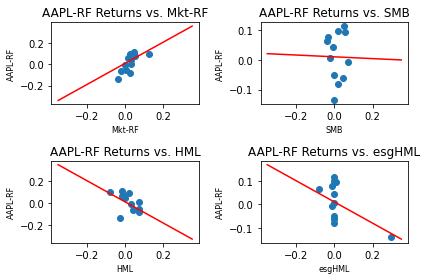

In [ ]:
# @ Denalia DO NEED
# Plot for highMinusLow vs Expected Return - RF
for i in range(X.shape[1]):

  const = results.params[0]
  coef = results.params[i+1]

  x_axis = np.linspace(-0.35, 0.35, 500)
  y_axis = const + coef * x_axis

  plt.subplot(2,2,i+1)

  plt.title(f'{y.columns[0]} Returns vs. {X.columns[i]}')

  plt.xlabel(X.columns[i], fontsize=8)
  plt.ylabel(y.columns[0], fontsize=8)

  plt.scatter(X.iloc[:,i],y)
  plt.plot(x_axis,y_axis,c='r')

  plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


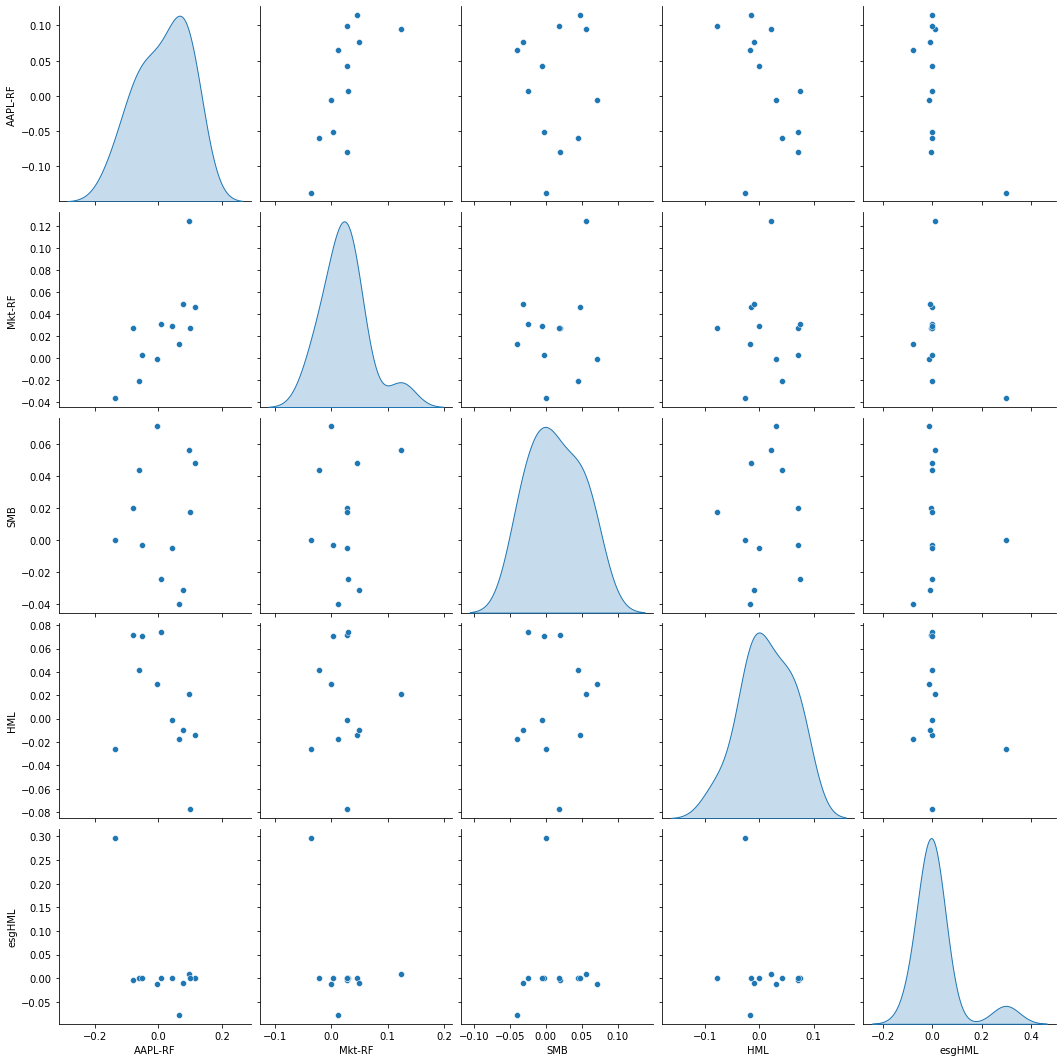

In [ ]:
# Idk implement if you wanna I guess?
import seaborn as sns
sns.pairplot(pd.concat([y,X], axis=1), palette="Set2", diag_kind="kde", size=3)

# Section 5.1
## ESG Comparison/S&P 500 Visualization Portion
### @ Denalia DO NEED


In [ ]:
knn_DF = sp_combined[['Symbol', 'socialScore', 'environmentScore', 'governanceScore']]
target_company1 = input('What is the ticker for your first target company 1? \t')
target_company2 = input('What is the ticker for your second target company 1? \t')

target_ESG1 = knn_DF[(knn_DF['Symbol'] == target_company1)]
target_ESG2 = knn_DF[(knn_DF['Symbol'] == target_company2)]

What is the ticker for your first target company 1? 	AAPL
What is the ticker for your second target company 1? 	MSFT


In [ ]:
symbol1 = target_ESG1.iloc[0,0]
symbol2 = target_ESG2.iloc[0,0]

name1 = sp_combined[(sp_combined['Symbol']==symbol1)].iloc[0,1]
name2 = sp_combined[(sp_combined['Symbol']==symbol2)].iloc[0,1]

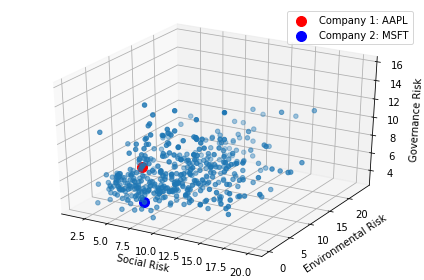

In [ ]:
%matplotlib notebook
# Situation where both companies are in same industry, where both scompanies are in different industries
# Compare the closeness between two companies
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(knn_DF.loc[:,'socialScore'],knn_DF.loc[:,'environmentScore'], knn_DF.loc[:,'governanceScore'])
ax.scatter(target_ESG1['socialScore'], target_ESG1['environmentScore'], target_ESG1['governanceScore'], c='r', label=f'Company 1: {name1}', s=100)
ax.scatter(target_ESG2['socialScore'], target_ESG2['environmentScore'], target_ESG2['governanceScore'], c='b', label=f'Company 2: {name2}', s=100)

ax.legend(loc='best')
ax.set_xlabel('Social Risk')
ax.set_ylabel('Environmental Risk')
ax.set_zlabel('Governance Risk')

# Add different color for specific company and if possible, lable pointing to specific company
# Add kNN information for 'closest ESG profile' for specific company
## Add different color, label (if possible)
plt.tight_layout()
plt.show()

In [ ]:
%matplotlib inline

# Section 5.2
## esgNearest-Neighbor (eNN) Portion
### @ Denalia DO NEED


In [ ]:
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors as nn

# Specifies samples as each of the ESG scores but not the symbol
# ** NOTE ** Code uses the company symbols/names/full names from Section 5.1 visualization
samples = sp_combined.loc[(sp_combined['Symbol'] != symbol1), ['environmentScore', 'socialScore', 'governanceScore']]
neigh = nn(n_neighbors=1)
neigh.fit(samples)

NearestNeighbors(n_neighbors=1)

In [ ]:
# Finds the row in kneighborw of 'samples' that is specific to the returned values
ret_arr = neigh.kneighbors(sp_combined.loc[(sp_combined['Symbol'] == symbol1), ['environmentScore', 'socialScore', 'governanceScore']])[1][0][0]

comp_ESG1 = samples.iloc[[ret_arr]] # Finds the ESG scores associated with the array index 'ret_arr'
comp_ESG_symbol = pd.merge(comp_ESG1, sp_combined, on=['environmentScore', 'socialScore', 'governanceScore'], how='inner')[['Symbol']] # Finds the symbol associated with the given array in sp_combined_

compname1 = sp_combined[(sp_combined['Symbol']==comp_ESG_symbol.iloc[0,0])].iloc[0,1]# Name associated with symbol

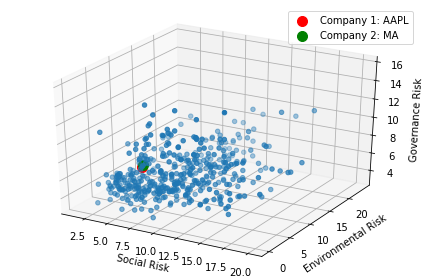

In [ ]:
%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(knn_DF.loc[:,'socialScore'],knn_DF.loc[:,'environmentScore'], knn_DF.loc[:,'governanceScore'])
ax.scatter(target_ESG1['socialScore'], target_ESG1['environmentScore'], target_ESG1['governanceScore'], c='r', label=f'Company 1: {name1}', s=100)
ax.scatter(comp_ESG1['socialScore'], comp_ESG1['environmentScore'], comp_ESG1['governanceScore'], c='g', label=f'Company 2: {compname1}', s=100)

ax.legend(loc='best')
ax.set_xlabel('Social Risk')
ax.set_ylabel('Environmental Risk')
ax.set_zlabel('Governance Risk')

# Add different color for specific company and if possible, lable pointing to specific company
# Add kNN information for 'closest ESG profile' for specific company
## Add different color, label (if possible)
plt.tight_layout()

plt.show()

In [ ]:
%matplotlib inline

# Section 6.1(?)
## Company-Specific ESG, Fama-French Regression

In [ ]:
from collections import defaultdict

industries = sp_combined['Industry']
industries = industries.unique()

sector_dict1 = defaultdict(list)
for industry in industries:
  for key, value in histESG_DF.items():
    if sector_map[key] == industry:

      temp_ = histESG_DF[key][['esgScore', 'governanceScore', 'environmentScore', 'socialScore']].tail(13).pct_change().iloc[1:,:]
      temp = {}
      temp[key] = temp_
      
      sector_dict1[industry].append(temp)

In [ ]:
sector_dict1['Textiles & Apparel']

[]

In [ ]:
# Now you can run regression with percent change in price and percent change in ESG Score

In [ ]:
final_dict1 = defaultdict(list)
for industry, value in sectorHML.items():
  
  HML = sectorHML[industry]

  HML.index = factors.index
  final_DF = pd.concat([factors, HML], axis=1)
  final_dict1[industry].append(final_DF)

In [ ]:
final_dict1

defaultdict(list,
            {'Aerospace & Defense': [       Date  Mkt-RF     SMB     HML      RF    esgHML
              0   2020-09 -0.0363  0.0002 -0.0262  0.0001  0.000000
              1   2020-10 -0.0210  0.0441  0.0416  0.0001  0.000000
              2   2020-11  0.1247  0.0565  0.0213  0.0001  0.138029
              3   2020-12  0.0463  0.0482 -0.0143  0.0001  0.000000
              4   2021-01 -0.0003  0.0712  0.0299  0.0000  0.000000
              5   2021-02  0.0278  0.0203  0.0718  0.0000  0.000000
              6   2021-03  0.0308 -0.0241  0.0741  0.0000  0.000000
              7   2021-04  0.0493 -0.0311 -0.0093  0.0000 -0.055509
              8   2021-05  0.0029 -0.0028  0.0704  0.0000  0.000000
              9   2021-06  0.0275  0.0180 -0.0776  0.0000  0.000000
              10  2021-07  0.0127 -0.0396 -0.0175  0.0000 -0.047605
              11  2021-08  0.0290 -0.0048 -0.0013  0.0000  0.000000],
             'Auto Components': [       Date  Mkt-RF     SMB     HML     

# Appendix 1.1
## Legacy Code

In [ ]:
# Uses the Yahoo Finance Built-In api to retrieve most recent information on ESG by symbol
midway_df = pd.DataFrame([])

# Uses tqdm to estimate runtime
for symbol in tqdm(test_symbols):
  try:
    symbol_y = yf.Ticker(symbol)
    esg_data = pd.DataFrame.transpose(symbol_y.sustainability)
    esg_data['Symbol'] = symbol
    
    to_midway = esg_data[['Symbol', 'governanceScore', 'environmentScore', 'socialScore']]
    midway_df = pd.concat([midway_df, to_midway])

    time.sleep(5)
  except:
    continue

In [ ]:
## Company name vs ticker
# Courtesy of Codex
def create_dictionary(keys, values):
    return dict(zip(keys, values))

In [ ]:
## Company name, versus company ticker checker
# Courtesy of Codex
def check_capital(string):
    pattern = re.compile(r'[A-Z]{4}')
    if pattern.search(string):
        return True
    else:
        return False

In [ ]:
# Legacy code to create histESG_DF dictionary, not dataframe
histESG_DF = {}
midway_df = pd.DataFrame([])
# Switch test_symbols with symbols
for key in symbols_divided.keys():

  for symbol in tqdm(symbols_divided[key]):
    url = 'https://query2.finance.yahoo.com/v1/finance/esgChart?symbol='
    url = url + symbol
    
    connection = urllib.request.urlopen(url)

    try: 
      data = connection.read()
      data_2 = json.loads(data)

      formatdata = data_2["esgChart"]["result"][0]["symbolSeries"]

      formatdata_2 = pd.DataFrame(formatdata)
      formatdata_2["timestamp"] = pd.to_datetime(formatdata_2["timestamp"], unit="s")

      # New formatting of ESG scores starts from 12/1/2019 onwards
      # Are formatted as risk scores:
      # https://www.excelpricefeed.com/userguide/excel-formula-yahoo-finance/esg-risk-ratings
      histESG = formatdata_2.tail(22)
      
      # Interpolate scores using nearest neighbor algorithm applied rowise
      # This is due to the scores only changing once ever 2 or 3 months
      # Scores are given in the format of score(Risk)
      histESG = histESG.interpolate(method='nearest', axis=0)

      print(f'Testing for legacy ratings and NaN values in {symbol}')

      # Filters out companies with old scores that are greater than 40
      if not histESG.tail(1)[(histESG.tail(1)['socialScore'] > 40)].empty and not histESG.tail(1)[(histESG.tail(1)['governanceScore'] > 40)].empty and not histESG.tail(1)[(histESG.tail(1)['enviornmentScore'] > 40)].empty:
        print(f'Legacy score found for {symbol}, dropping dataframe')
        continue # Goes to next company if any last entry of histESG is empty
      print(f'No scores greater than 40 for {symbol}')

      # Or companies with NaN ESG scores
      if histESG.isnull().values.any():
        print(f'NaN value found for {symbol}, dropping dataframe')
        continue
      print(f'No null values for {symbol}')

      # Creates a variable representing industry of companies
      peerGroup = data_2['esgChart']['result'][0]['peerGroup']

      # Creates appendages of the main dataframe
      to_midway = formatdata_2.tail(1) # Midway dataframe will only use the most resent row of ESG data
      to_midway['Symbol'] = symbol # Sets the symbol of the current company to the symbol of the company
      to_midway['Industry'] = peerGroup # Sets the industry of the current company to it's industry

      midway_df = pd.concat([midway_df, to_midway]).drop(columns='timestamp')

      # Creates a dictionary of ESG scores alongside their respective company
      # INiates such that his dataframe has columns corresponding to its specific symbol
      map = {'esgScore': f'{symbol} esgScore',
             'governanceScore': f'{symbol} governanceScore',
             'socialScore': f'{symbol} socialScore',
             'environmentScore': f'{symbol} environmentScore'}
      histESG_DF[symbol] = histESG.rename(columns=map).drop(columns='timestamp')

      print(histESG_DF[symbol])
    except:
      print(f'Exception found for {symbol}')
      continue

  # Yahoo Finance API refusing connection, requires time.sleep
  time.sleep(60)

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  2%|▏         | 1/50 [00:00<00:06,  7.72it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Testing for legacy ratings and NaN values in MMM
No scores greater than 40 for MMM
No null values for MMM
    MMM esgScore  MMM governanceScore  MMM environmentScore  MMM socialScore
63         34.53                 9.23                 12.60            12.70
64         34.53                 9.23                 12.60            12.70
65         34.53                 9.23                 12.60            12.70
66         33.54                 8.39                 12.60            12.55
67         33.54                 8.39                 12.60            12.55
68         33.54                 8.39                 12.60            12.55
69         34.75                 8.07                 12.79            13.89
70         34.75                 8.07                 12.79            13.89
71         34.75                 8.07                 12.79            13.89
72         34.75                 8.07                 12.79            13.89
73         34.86                 8.07          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 10%|█         | 5/50 [00:00<00:03, 14.26it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Exception found for ABMD
Testing for legacy ratings and NaN values in ACN
No scores greater than 40 for ACN
No null values for ACN
    ACN esgScore  ACN governanceScore  ACN environmentScore  ACN socialScore
63         15.32                 6.17                  0.96             8.19
64         15.32                 6.17                  0.96             8.19
65         15.45                 6.30                  0.96             8.19
66         15.45                 6.30                  0.96             8.19
67         15.45                 6.30                  0.96             8.19
68         15.45                 6.30                  0.96             8.19
69         11.24                 5.71                  0.55             4.98
70         11.24                 5.71                  0.55             4.98
71         11.24                 5.71                  0.55             4.98
72         11.24                 5.71                  0.55             4.98
73         11.24      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Exception found for AMD
Testing for legacy ratings and NaN values in AAP
No scores greater than 40 for AAP
No null values for AAP
    AAP esgScore  AAP governanceScore  AAP environmentScore  AAP socialScore
63         44.92                61.50                 38.03            40.59
64         13.38                 4.15                  0.14             9.09
65         12.91                 3.68                  0.14             9.09
66         12.91                 3.68                  0.14             9.09
67         12.91                 3.68                  0.14             9.09
68         12.91                 3.68                  0.14             9.09
69         12.38                 3.61                  0.10             8.67
70         12.38                 3.61                  0.10             8.67
71         12.38                 3.61                  0.10             8.67
72         12.38                 3.61                  0.10             8.67
73         12.40       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in A
No scores greater than 40 for A
No null values for A
    A esgScore  A governanceScore  A environmentScore  A socialScore
63       66.38              60.62               83.62          60.66
64       17.52               7.23                0.87           9.42
65       17.52               7.23                0.87           9.42
66       17.52               7.23                0.87           9.42
67       17.52               7.23                0.87           9.42
68       17.52               7.23                0.87           9.42
69       16.79               6.50                0.87           9.42
70       16.79               6.50                0.87           9.42
71       16.79               6.50                0.87           9.42
72       16.79               6.50                0.87           9.42
73       16.72               6.45                0.87           9.40
74       16.72               6.45                0.87           9.40
75 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ALB
No scores greater than 40 for ALB
No null values for ALB
    ALB esgScore  ALB governanceScore  ALB environmentScore  ALB socialScore
63         57.82                64.39                 47.05            65.44
64         37.26                 8.67                 19.68             8.91
65         37.26                 8.67                 19.68             8.91
66         37.26                 8.67                 19.68             8.91
67         37.26                 8.67                 19.68             8.91
68         37.26                 8.67                 19.68             8.91
69         36.72                 8.72                 19.09             8.91
70         36.72                 8.72                 19.09             8.91
71         36.72                 8.72                 19.09             8.91
72         36.72                 8.72                 19.09             8.91
73         36.74                 8.74          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


    LNT esgScore  LNT governanceScore  LNT environmentScore  LNT socialScore
63         63.97                74.65                 54.07            69.92
64         35.42                 6.84                 18.53            10.05
65         35.42                 6.84                 18.53            10.05
66         35.42                 6.84                 18.53            10.05
67         35.42                 6.84                 18.53            10.05
68         35.42                 6.84                 18.53            10.05
69         36.02                 6.69                 19.28            10.05
70         36.02                 6.69                 19.28            10.05
71         28.44                 6.46                 14.76             7.22
72         28.44                 6.46                 14.76             7.22
73         28.44                 6.46                 14.76             7.22
74         28.44                 6.46                 14.76             7.2

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 48%|████▊     | 24/50 [00:01<00:01, 17.72it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in MO
No scores greater than 40 for MO
No null values for MO
    MO esgScore  MO governanceScore  MO environmentScore  MO socialScore
63        24.75                6.09                 6.32           12.33
64        25.03                6.30                 6.32           12.41
65        25.05                5.93                 6.26           12.85
66        25.05                5.93                 6.26           12.85
67        25.05                5.93                 6.26           12.85
68        25.05                5.93                 6.26           12.85
69        24.82                6.07                 5.81           12.93
70        24.82                6.07                 5.81           12.93
71        24.99                6.24                 5.81           12.93
72        24.99                6.24                 5.81           12.93
73        25.01                6.26                 5.81           12.93
74        25.01      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in AAL
No scores greater than 40 for AAL
No null values for AAL
    AAL esgScore  AAL governanceScore  AAL environmentScore  AAL socialScore
63         55.48                66.09                 43.41            59.42
64         31.50                 6.18                 11.58            13.74
65         31.53                 6.18                 11.58            13.77
66         30.49                 5.38                 10.93            14.18
67         30.49                 5.38                 10.93            14.18
68         30.49                 5.38                 10.93            14.18
69         30.59                 5.48                 10.93            14.18
70         30.59                 5.48                 10.93            14.18
71         30.59                 5.48                 10.93            14.18
72         30.59                 5.48                 10.93            14.18
73         30.62                 5.51          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    AIG esgScore  AIG governanceScore  AIG environmentScore  AIG socialScore
63         29.44                15.99                  1.86            11.58
64         29.44                15.99                  1.86            11.58
65         29.44                15.99                  1.86            11.58
66         29.44                15.99                  1.86            11.58
67         29.44                15.99                  1.86            11.58
68         29.44                15.99                  1.86            11.58
69         32.12                15.97                  1.92            14.23
70         32.12                15.97                  1.92            14.23
71         32.12                15.97                  1.92            14.23
72         32.12                15.97                  1.92            14.23
73         30.68                15.13                  1.99            13.56
74         30.68                15.13                  1.99            13.56

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ABC
No scores greater than 40 for ABC
No null values for ABC
    ABC esgScore  ABC governanceScore  ABC environmentScore  ABC socialScore
63         53.81                57.69                 67.63            43.54
64         17.92                 6.14                  2.64             9.14
65         17.92                 6.14                  2.64             9.14
66         17.88                 6.10                  2.64             9.14
67         17.88                 6.10                  2.64             9.14
68         17.88                 6.10                  2.64             9.14
69         17.78                 5.98                  2.75             9.05
70         17.78                 5.98                  2.75             9.05
71         13.59                 5.76                  2.33             5.51
72         13.59                 5.76                  2.33             5.51
73         12.90                 5.78          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 76%|███████▌  | 38/50 [00:02<00:00, 14.57it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat


    APH esgScore  APH governanceScore  APH environmentScore  APH socialScore
63         57.73                58.30                 52.15            63.72
64         24.06                 7.77                 10.35             5.93
65         24.09                 7.77                 10.35             5.97
66         24.09                 7.77                 10.35             5.97
67         24.09                 7.77                 10.35             5.97
68         24.09                 7.77                 10.35             5.97
69         23.81                 7.77                 10.02             6.02
70         23.81                 7.77                 10.02             6.02
71         23.81                 7.77                 10.02             6.02
72         23.81                 7.77                 10.02             6.02
73         23.81                 7.77                 10.02             6.02
74         23.81                 7.77                 10.02             6.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ANTM
No scores greater than 40 for ANTM
No null values for ANTM
    ANTM esgScore  ...  ANTM socialScore
63          23.83  ...             17.07
64          23.75  ...             17.07
65          16.70  ...             10.24
66          16.70  ...             10.24
67          16.70  ...             10.24
68          16.70  ...             10.24
69          16.70  ...             10.24
70          16.70  ...             10.24
71          16.70  ...             10.24
72          16.70  ...             10.24
73          15.94  ...              9.77
74          15.94  ...              9.77
75          12.27  ...              6.97
76          12.27  ...              6.97
77          12.27  ...              6.97
78          12.27  ...              6.97
79          12.27  ...              6.97
80          12.27  ...              6.97
81          12.27  ...              6.97
82          12.27  ...              6.97
83          11.81  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in AAPL
No scores greater than 40 for AAPL
No null values for AAPL
    AAPL esgScore  ...  AAPL socialScore
63          23.60  ...             12.63
64          23.82  ...             13.00
65          23.82  ...             13.00
66          23.82  ...             13.00
67          23.82  ...             13.00
68          23.82  ...             13.00
69          23.62  ...             12.98
70          23.62  ...             12.98
71          23.62  ...             12.98
72          23.62  ...             12.98
73          23.65  ...             12.98
74          23.65  ...             12.98
75          16.46  ...              7.55
76          16.46  ...              7.55
77          16.58  ...              7.55
78          16.73  ...              7.69
79          16.73  ...              7.69
80          16.92  ...              7.69
81          16.92  ...              7.69
82          16.92  ...              7.69
83          16.92  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ANET
No scores greater than 40 for ANET
No null values for ANET
    ANET esgScore  ...  ANET socialScore
32          54.52  ...             53.68
33          19.52  ...              9.64
34          19.52  ...              9.64
35          19.52  ...              9.64
36          19.52  ...              9.64
37          19.52  ...              9.64
38          19.35  ...              9.64
39          19.35  ...              9.64
40          17.62  ...              9.06
41          17.62  ...              9.06
42          17.62  ...              9.06
43          17.62  ...              9.06
44          17.62  ...              9.06
45          17.62  ...              9.06
46          17.62  ...              9.06
47          17.62  ...              9.06
48          17.62  ...              9.06
49          17.62  ...              9.06
50          17.62  ...              9.06
51          17.62  ...              9.06
52          17.89  ...        

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Testing for legacy ratings and NaN values in AIZ
No scores greater than 40 for AIZ
No null values for AIZ
    AIZ esgScore  AIZ governanceScore  AIZ environmentScore  AIZ socialScore
63         52.30                53.72                 50.16            52.64
64         26.29                13.64                  1.38            11.27
65         26.29                13.64                  1.38            11.27
66         26.29                13.64                  1.38            11.27
67         26.29                13.64                  1.38            11.27
68         26.29                13.64                  1.38            11.27
69         26.02                13.37                  1.38            11.27
70         26.02                13.37                  1.38            11.27
71         26.02                13.37                  1.38            11.27
72         26.02                13.37                  1.38            11.27
73         25.15                13.25          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ADP
No scores greater than 40 for ADP
No null values for ADP
    ADP esgScore  ADP governanceScore  ADP environmentScore  ADP socialScore
63         14.81                 6.44                  0.07             8.30
64         14.81                 6.44                  0.07             8.30
65         14.81                 6.44                  0.07             8.30
66         14.52                 6.15                  0.07             8.30
67         14.52                 6.15                  0.07             8.30
68         14.52                 6.15                  0.07             8.30
69         12.40                 5.66                  0.07             6.67
70         12.40                 5.66                  0.07             6.67
71         12.40                 5.66                  0.07             6.67
72         12.40                 5.66                  0.07             6.67
73         12.82                 5.68          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 20%|██        | 10/50 [00:00<00:02, 17.07it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for BKR
Testing for legacy ratings and NaN values in BLL
No scores greater than 40 for BLL
No null values for BLL
    BLL esgScore  BLL governanceScore  BLL environmentScore  BLL socialScore
63         75.45                64.65                 73.63            85.25
64         14.89                 4.46                  9.41             1.02
65         14.89                 4.46                  9.41             1.02
66         14.89                 4.46                  9.41             1.02
67         14.89                 4.46                  9.41             1.02
68         14.89                 4.46                  9.41             1.02
69         16.20                 4.45                 10.27             1.47
70         16.20                 4.45                 10.27             1.47
71         15.38                 4.07                 10.02             1.29
72         15.38                 4.07                 10.02             1.29
73         15.40       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in BAX
No scores greater than 40 for BAX
No null values for BAX
    BAX esgScore  BAX governanceScore  BAX environmentScore  BAX socialScore
63         63.54                66.62                 69.90            57.96
64         28.93                 8.83                  2.63            17.47
65         28.93                 8.83                  2.63            17.47
66         28.93                 8.83                  2.63            17.47
67         28.93                 8.83                  2.63            17.47
68         28.93                 8.83                  2.63            17.47
69         27.97                 9.26                  2.49            16.22
70         27.97                 9.26                  2.49            16.22
71         27.97                 9.26                  2.49            16.22
72         27.97                 9.26                  2.49            16.22
73         27.99                 9.28          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 36%|███▌      | 18/50 [00:01<00:01, 16.53it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in BIO
No scores greater than 40 for BIO
No null values for BIO
    BIO esgScore  BIO governanceScore  BIO environmentScore  BIO socialScore
63         59.24                67.60                 62.84            51.67
64         21.59                 7.52                  1.52            12.55
65         21.59                 7.52                  1.52            12.55
66         21.66                 7.59                  1.52            12.55
67         21.66                 7.59                  1.52            12.55
68         21.66                 7.59                  1.52            12.55
69         21.56                 7.14                  1.52            12.91
70         21.56                 7.14                  1.52            12.91
71         21.56                 7.14                  1.52            12.91
72         21.56                 7.14                  1.52            12.91
73         21.07                 7.25          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in BK
No scores greater than 40 for BK
No null values for BK
    BK esgScore  BK governanceScore  BK environmentScore  BK socialScore
63        24.76               10.22                 2.37           12.18
64        24.76               10.22                 2.37           12.18
65        24.76               10.22                 2.37           12.18
66        24.23                9.97                 2.47           11.79
67        24.23                9.97                 2.47           11.79
68        24.23                9.97                 2.47           11.79
69        21.49               10.13                 2.02            9.33
70        21.49               10.13                 2.02            9.33
71        21.49               10.13                 2.02            9.33
72        21.49               10.13                 2.02            9.33
73        22.60               11.25                 2.02            9.33
74        22.60      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in BXP
No scores greater than 40 for BXP
No null values for BXP
    BXP esgScore  BXP governanceScore  BXP environmentScore  BXP socialScore
63         66.60                78.16                 66.26            55.49
64         14.35                 5.44                  3.82             5.09
65         14.35                 5.44                  3.82             5.09
66         14.35                 5.44                  3.82             5.09
67         14.35                 5.44                  3.82             5.09
68         14.35                 5.44                  3.82             5.09
69         14.35                 5.44                  3.82             5.09
70         14.35                 5.44                  3.82             5.09
71         14.35                 5.44                  3.82             5.09
72         14.35                 5.44                  3.82             5.09
73         13.91                 5.01          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in AVGO
No scores greater than 40 for AVGO
No null values for AVGO
    AVGO esgScore  ...  AVGO socialScore
63          25.88  ...              8.25
64          25.88  ...              8.25
65          26.24  ...              8.25
66          26.24  ...              8.25
67          26.24  ...              8.25
68          26.24  ...              8.25
69          26.32  ...              8.46
70          26.32  ...              8.46
71          26.32  ...              8.46
72          26.32  ...              8.46
73          25.54  ...              8.66
74          25.54  ...              8.66
75          25.54  ...              8.66
76          25.54  ...              8.66
77          25.54  ...              8.66
78          25.54  ...              8.66
79          25.54  ...              8.66
80          25.54  ...              8.66
81          25.54  ...              8.66
82          25.54  ...              8.66
83          25.42  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 64%|██████▍   | 32/50 [00:02<00:01, 15.19it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for BF.B
Testing for legacy ratings and NaN values in CHRW
No scores greater than 40 for CHRW
No null values for CHRW
    CHRW esgScore  ...  CHRW socialScore
63          45.36  ...             42.27
64          25.91  ...             12.91
65          25.91  ...             12.91
66          25.63  ...             12.91
67          25.63  ...             12.91
68          25.63  ...             12.91
69          25.96  ...             13.08
70          25.96  ...             13.08
71          25.96  ...             13.08
72          25.96  ...             13.08
73          25.99  ...             13.08
74          25.99  ...             13.08
75          25.98  ...             13.08
76          25.98  ...             13.08
77          25.98  ...             13.08
78          25.74  ...             13.08
79          25.74  ...             13.08
80          24.66  ...             13.08
81          24.66  ...             13.08
82          24.66  ...             13.08
83   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CPB
No scores greater than 40 for CPB
No null values for CPB
    CPB esgScore  CPB governanceScore  CPB environmentScore  CPB socialScore
63         71.15                73.48                 77.72            63.96
64         24.36                 5.46                  8.97             9.93
65         24.36                 5.46                  8.97             9.93
66         24.36                 5.46                  8.97             9.93
67         24.36                 5.46                  8.97             9.93
68         24.36                 5.46                  8.97             9.93
69         22.00                 4.88                  9.34             7.79
70         22.00                 4.88                  9.34             7.79
71         22.00                 4.88                  9.34             7.79
72         22.00                 4.88                  9.34             7.79
73         22.00                 4.88          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 80%|████████  | 40/50 [00:02<00:00, 16.44it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in CCL
No scores greater than 40 for CCL
No null values for CCL
    CCL esgScore  CCL governanceScore  CCL environmentScore  CCL socialScore
63         20.10                 3.65                  8.30             8.16
64         20.10                 3.65                  8.30             8.16
65         20.10                 3.65                  8.30             8.16
66         21.86                 3.65                  9.04             9.17
67         21.86                 3.65                  9.04             9.17
68         21.86                 3.65                  9.04             9.17
69         21.72                 3.79                  8.43             9.50
70         21.72                 3.79                  8.43             9.50
71         21.72                 3.79                  8.43             9.50
72         21.72                 3.79                  8.43             9.50
73         21.72                 3.79          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CBOE
No scores greater than 40 for CBOE
No null values for CBOE
    CBOE esgScore  ...  CBOE socialScore
63          44.55  ...             55.45
64          21.69  ...              9.24
65          21.69  ...              9.24
66          21.69  ...              9.24
67          21.69  ...              9.24
68          21.69  ...              9.24
69          21.69  ...              9.24
70          21.69  ...              9.24
71          21.69  ...              9.24
72          21.69  ...              9.24
73          21.38  ...              9.22
74          21.38  ...              9.22
75          18.65  ...              7.19
76          18.65  ...              7.19
77          18.65  ...              7.19
78          18.65  ...              7.19
79          18.65  ...              7.19
80          18.65  ...              7.19
81          18.65  ...              7.19
82          18.65  ...              7.19
83          18.87  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 92%|█████████▏| 46/50 [00:02<00:00, 16.13it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    CE esgScore  CE governanceScore  CE environmentScore  CE socialScore
63        57.83               63.15                58.71           53.03
64        34.36                9.13                15.04           10.18
65        34.36                9.13                15.04           10.18
66        30.30                7.71                14.89            7.71
67        30.30                7.71                14.89            7.71
68        30.30                7.71                14.89            7.71
69        29.85                7.28                14.86            7.71
70        29.85                7.28                14.86            7.71
71        29.85                7.28                14.86            7.71
72        29.85                7.28                14.86            7.71
73        29.87                7.31                14.86            7.71
74        29.87                7.31                14.86            7.71
75        29.87                7.31                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 50/50 [00:03<00:00, 15.77it/s]


Testing for legacy ratings and NaN values in CERN
No scores greater than 40 for CERN
No null values for CERN
    CERN esgScore  ...  CERN socialScore
63          50.98  ...             42.49
64          19.89  ...             12.89
65          19.89  ...             12.89
66          19.89  ...             12.89
67          19.89  ...             12.89
68          19.89  ...             12.89
69          20.10  ...             12.89
70          20.10  ...             12.89
71          20.10  ...             12.89
72          20.10  ...             12.89
73          20.12  ...             12.89
74          20.12  ...             12.89
75          19.87  ...             12.89
76          19.87  ...             12.89
77          19.87  ...             12.89
78          19.87  ...             12.89
79          19.87  ...             12.89
80          19.87  ...             12.89
81          19.87  ...             12.89
82          19.87  ...             12.89
83          19.80  ...        

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  4%|▍         | 2/50 [00:00<00:02, 17.33it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Testing for legacy ratings and NaN values in CF
No scores greater than 40 for CF
No null values for CF
    CF esgScore  CF governanceScore  CF environmentScore  CF socialScore
63        50.49               67.35                39.92           50.53
64        48.43                7.83                24.42           16.18
65        48.25                7.93                24.04           16.28
66        48.25                7.93                24.04           16.28
67        48.25                7.93                24.04           16.28
68        48.25                7.93                24.04           16.28
69        47.74                7.42                24.04           16.28
70        47.74                7.42                24.04           16.28
71        47.74                7.42                24.04           16.28
72        47.74                7.42                24.04           16.28
73        32.84                5.14                18.50            9.20
74        32.84      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CVX
No scores greater than 40 for CVX
No null values for CVX
    CVX esgScore  CVX governanceScore  CVX environmentScore  CVX socialScore
63         42.15                10.25                 20.20            11.70
64         42.15                10.25                 20.20            11.70
65         42.15                10.25                 20.20            11.70
66         39.59                10.25                 17.82            11.53
67         39.59                10.25                 17.82            11.53
68         39.59                10.25                 17.82            11.53
69         40.22                 9.91                 18.34            11.98
70         40.22                 9.91                 18.34            11.98
71         40.26                 9.95                 18.34            11.98
72         40.26                 9.95                 18.34            11.98
73         40.29                 9.98          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 16%|█▌        | 8/50 [00:00<00:02, 14.98it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati


No null values for CHD
    CHD esgScore  CHD governanceScore  CHD environmentScore  CHD socialScore
63         64.75                66.85                 62.16            65.71
64         25.45                 7.96                  8.87             8.62
65         25.45                 7.96                  8.87             8.62
66         25.45                 7.96                  8.87             8.62
67         25.45                 7.96                  8.87             8.62
68         25.45                 7.96                  8.87             8.62
69         25.23                 7.96                  8.65             8.62
70         25.23                 7.96                  8.65             8.62
71         25.23                 7.96                  8.65             8.62
72         25.23                 7.96                  8.65             8.62
73         25.23                 7.96                  8.65             8.62
74         25.23                 7.96               

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 24%|██▍       | 12/50 [00:00<00:02, 16.34it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in CSCO
No scores greater than 40 for CSCO
No null values for CSCO
    CSCO esgScore  ...  CSCO socialScore
63          14.11  ...              6.59
64          14.11  ...              6.59
65          13.74  ...              6.59
66          13.74  ...              6.59
67          13.74  ...              6.59
68          13.74  ...              6.59
69          12.08  ...              5.68
70          12.08  ...              5.68
71          12.08  ...              5.68
72          12.08  ...              5.68
73          12.35  ...              5.94
74          12.35  ...              5.94
75          12.67  ...              5.94
76          12.67  ...              5.94
77          12.67  ...              5.94
78          12.55  ...              5.94
79          12.55  ...              5.94
80          12.45  ...              5.84
81          12.45  ...              5.84
82          12.45  ...              5.84
83          11.42  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CTXS
No scores greater than 40 for CTXS
No null values for CTXS
    CTXS esgScore  ...  CTXS socialScore
63          56.75  ...             56.55
64          18.21  ...             10.77
65          18.69  ...             11.25
66          18.69  ...             11.25
67          18.69  ...             11.25
68          18.69  ...             11.25
69          18.09  ...             11.25
70          18.09  ...             11.25
71          18.09  ...             11.25
72          18.09  ...             11.25
73          18.11  ...             11.25
74          18.11  ...             11.25
75          18.11  ...             11.25
76          18.11  ...             11.25
77          18.11  ...             11.25
78          18.11  ...             11.25
79          18.11  ...             11.25
80          14.20  ...              7.97
81          14.20  ...              7.97
82          14.20  ...              7.97
83          14.57  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CMS
No scores greater than 40 for CMS
No null values for CMS
    CMS esgScore  CMS governanceScore  CMS environmentScore  CMS socialScore
63         80.27                82.05                 77.75            82.58
64         27.62                 4.93                 13.61             9.07
65         28.05                 5.36                 13.61             9.07
66         28.05                 5.36                 13.61             9.07
67         28.05                 5.36                 13.61             9.07
68         28.05                 5.36                 13.61             9.07
69         27.97                 5.48                 13.42             9.07
70         27.97                 5.48                 13.42             9.07
71         27.97                 5.48                 13.42             9.07
72         27.97                 5.48                 13.42             9.07
73         27.99                 5.50          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CL
No scores greater than 40 for CL
No null values for CL
    CL esgScore  CL governanceScore  CL environmentScore  CL socialScore
63        22.11                6.68                 6.48            8.94
64        22.11                6.68                 6.48            8.94
65        22.11                6.68                 6.48            8.94
66        21.80                6.37                 6.48            8.94
67        21.80                6.37                 6.48            8.94
68        21.80                6.37                 6.48            8.94
69        21.82                6.22                 6.65            8.94
70        21.82                6.22                 6.65            8.94
71        22.10                5.94                 6.79            9.37
72        22.10                5.94                 6.79            9.37
73        22.12                5.96                 6.79            9.37
74        22.12      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in COP
No scores greater than 40 for COP
No null values for COP
    COP esgScore  COP governanceScore  COP environmentScore  COP socialScore
63         30.75                 6.67                 16.24             7.84
64         30.75                 6.67                 16.24             7.84
65         30.75                 6.67                 16.24             7.84
66         30.75                 6.67                 16.24             7.84
67         30.75                 6.67                 16.24             7.84
68         30.75                 6.67                 16.24             7.84
69         29.06                 6.74                 14.48             7.84
70         29.06                 6.74                 14.48             7.84
71         29.38                 6.51                 15.03             7.84
72         29.38                 6.51                 15.03             7.84
73         29.33                 6.53          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CPRT
No scores greater than 40 for CPRT
No null values for CPRT
    CPRT esgScore  ...  CPRT socialScore
63          45.73  ...             42.83
64          24.03  ...             11.46
65          24.03  ...             11.46
66          24.03  ...             11.46
67          24.03  ...             11.46
68          24.03  ...             11.46
69          23.41  ...             11.46
70          23.41  ...             11.46
71          23.41  ...             11.46
72          23.41  ...             11.46
73          23.43  ...             11.46
74          23.43  ...             11.46
75          23.01  ...             11.76
76          23.01  ...             11.76
77          23.01  ...             11.76
78          23.01  ...             11.76
79          23.01  ...             11.76
80          22.71  ...             11.76
81          22.71  ...             11.76
82          22.71  ...             11.76
83          22.71  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 64%|██████▍   | 32/50 [00:02<00:01, 14.71it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in COST
No scores greater than 40 for COST
No null values for COST
    COST esgScore  ...  COST socialScore
63          22.54  ...             10.84
64          22.54  ...             10.84
65          22.40  ...             10.84
66          22.40  ...             10.84
67          22.40  ...             10.84
68          22.40  ...             10.84
69          22.84  ...             10.84
70          22.84  ...             10.84
71          22.78  ...             10.72
72          22.78  ...             10.72
73          22.32  ...             10.94
74          22.32  ...             10.94
75          22.32  ...             10.94
76          22.32  ...             10.94
77          22.22  ...             10.94
78          22.37  ...             10.94
79          22.37  ...             10.94
80          23.20  ...             11.02
81          23.20  ...             11.02
82          23.20  ...             11.02
83          23.20  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in CMI
No scores greater than 40 for CMI
No null values for CMI
    CMI esgScore  CMI governanceScore  CMI environmentScore  CMI socialScore
63         67.18                69.09                 68.68            64.09
64         18.82                 6.36                  3.35             9.11
65         18.82                 6.36                  3.35             9.11
66         18.82                 6.36                  3.35             9.11
67         18.82                 6.36                  3.35             9.11
68         18.82                 6.36                  3.35             9.11
69         19.10                 6.36                  3.46             9.28
70         19.10                 6.36                  3.46             9.28
71         19.11                 6.37                  3.46             9.28
72         19.11                 6.37                  3.46             9.28
73         17.83                 5.95          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


No scores greater than 40 for DHR
No null values for DHR
    DHR esgScore  DHR governanceScore  DHR environmentScore  DHR socialScore
63         32.72                 9.86                  4.63            18.23
64         32.72                 9.86                  4.63            18.23
65         32.72                 9.86                  4.63            18.23
66         32.72                 9.86                  4.63            18.23
67         32.72                 9.86                  4.63            18.23
68         32.72                 9.86                  4.63            18.23
69         32.72                 9.86                  4.63            18.23
70         32.72                 9.86                  4.63            18.23
71         32.72                 9.86                  4.63            18.23
72         32.72                 9.86                  4.63            18.23
73         32.72                 9.86                  4.63            18.23
74         32.72  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DE
No scores greater than 40 for DE
No null values for DE
    DE esgScore  DE governanceScore  DE environmentScore  DE socialScore
59        60.69               57.45                69.14           53.32
60        60.69               57.45                69.14           53.32
61        60.83               57.45                69.50           53.32
62        61.08               58.45                69.50           53.32
63        60.40               59.35                67.25           53.31
64        18.94                3.49                 4.30           11.15
65        17.76                3.48                 4.53            9.75
66        17.76                3.48                 4.53            9.75
67        17.76                3.48                 4.53            9.75
68        17.76                3.48                 4.53            9.75
69        17.77                3.48                 4.54            9.75
70        17.77      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DVN
No scores greater than 40 for DVN
No null values for DVN
    DVN esgScore  DVN governanceScore  DVN environmentScore  DVN socialScore
63         68.92                75.88                 62.49            70.20
64         34.16                 6.13                 16.88            11.15
65         34.16                 6.13                 16.88            11.15
66         34.42                 6.13                 17.14            11.15
67         34.42                 6.13                 17.14            11.15
68         34.42                 6.13                 17.14            11.15
69         33.25                 7.10                 17.47             8.68
70         33.25                 7.10                 17.47             8.68
71         33.25                 7.10                 17.47             8.68
72         33.25                 7.10                 17.47             8.68
73         33.51                 7.12          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DFS
No scores greater than 40 for DFS
No null values for DFS
    DFS esgScore  DFS governanceScore  DFS environmentScore  DFS socialScore
63         57.90                59.19                 43.40            69.94
64         20.82                 9.92                  0.11            10.80
65         20.82                 9.92                  0.11            10.80
66         20.82                 9.92                  0.11            10.80
67         20.82                 9.92                  0.11            10.80
68         20.82                 9.92                  0.11            10.80
69         23.54                 9.79                  0.11            13.64
70         23.54                 9.79                  0.11            13.64
71         23.54                 9.79                  0.11            13.64
72         23.54                 9.79                  0.11            13.64
73         23.56                 9.82          

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  4%|▍         | 2/50 [00:00<00:02, 18.10it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Exception found for DISCK
Testing for legacy ratings and NaN values in DISH
No scores greater than 40 for DISH
No null values for DISH
    DISH esgScore  ...  DISH socialScore
63          43.40  ...             39.68
64          20.61  ...              9.17
65          20.61  ...              9.17
66          21.38  ...              9.89
67          21.38  ...              9.89
68          21.38  ...              9.89
69          21.65  ...              9.89
70          21.65  ...              9.89
71          21.65  ...              9.89
72          21.65  ...              9.89
73          21.67  ...              9.89
74          21.67  ...              9.89
75          21.67  ...              9.89
76          21.67  ...              9.89
77          21.67  ...              9.89
78          22.22  ...             11.34
79          22.22  ...             11.34
80          22.48  ...             11.34
81          22.48  ...             11.34
82          22.48  ...             11.34
83  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in D
No scores greater than 40 for D
No null values for D
    D esgScore  D governanceScore  D environmentScore  D socialScore
63       34.83               6.20               17.87          10.76
64       34.63               6.20               17.67          10.76
65       32.40               6.20               15.65          10.55
66       32.21               6.20               15.46          10.55
67       32.21               6.20               15.46          10.55
68       32.21               6.20               15.46          10.55
69       32.25               6.23               15.46          10.55
70       32.25               6.23               15.46          10.55
71       33.21               6.23               16.42          10.55
72       33.21               6.23               16.42          10.55
73       33.23               6.25               16.42          10.55
74       33.23               6.25               16.42          10.55
75 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DTE
No scores greater than 40 for DTE
No null values for DTE
    DTE esgScore  DTE governanceScore  DTE environmentScore  DTE socialScore
63         71.91                79.29                 61.82            80.91
64         30.77                 6.39                 14.16            10.22
65         30.77                 6.39                 14.16            10.22
66         30.77                 6.39                 14.16            10.22
67         30.77                 6.39                 14.16            10.22
68         30.77                 6.39                 14.16            10.22
69         30.89                 6.43                 14.23            10.22
70         30.89                 6.43                 14.23            10.22
71         31.14                 6.20                 15.54             9.40
72         31.14                 6.20                 15.54             9.40
73         31.14                 6.20          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DXC
No scores greater than 40 for DXC
No null values for DXC
    DXC esgScore  DXC governanceScore  DXC environmentScore  DXC socialScore
31         63.60                69.99                 66.84            57.89
32         15.78                 5.83                  0.01             9.94
33         15.78                 5.83                  0.01             9.94
34         15.78                 5.83                  0.01             9.94
35         15.78                 5.83                  0.01             9.94
36         15.78                 5.83                  0.01             9.94
37         15.32                 5.36                  0.01             9.94
38         15.32                 5.36                  0.01             9.94
39         15.32                 5.36                  0.01             9.94
40         15.32                 5.36                  0.01             9.94
41         13.48                 5.17          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 32%|███▏      | 16/50 [00:01<00:02, 14.24it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in EBAY
No scores greater than 40 for EBAY
No null values for EBAY
    EBAY esgScore  ...  EBAY socialScore
63          60.38  ...             58.36
64          20.19  ...             11.13
65          20.20  ...             11.20
66          20.19  ...             11.13
67          20.19  ...             11.13
68          20.19  ...             11.13
69          21.42  ...             11.66
70          21.42  ...             11.66
71          21.42  ...             11.66
72          21.42  ...             11.66
73          21.44  ...             11.66
74          21.44  ...             11.66
75          21.78  ...             11.76
76          21.78  ...             11.76
77          21.78  ...             11.76
78          21.39  ...             11.76
79          21.39  ...             11.76
80          16.71  ...              9.33
81          16.71  ...              9.33
82          16.71  ...              9.33
83          16.71  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in EA
No scores greater than 40 for EA
No null values for EA
    EA esgScore  EA governanceScore  EA environmentScore  EA socialScore
63        52.47               66.15                45.98           49.20
64        14.82                5.69                 0.13            9.00
65        14.82                5.69                 0.13            9.00
66        14.82                5.69                 0.13            9.00
67        14.82                5.69                 0.13            9.00
68        14.82                5.69                 0.13            9.00
69        12.44                5.07                 0.13            7.25
70        12.44                5.07                 0.13            7.25
71        12.44                5.07                 0.13            7.25
72        12.44                5.07                 0.13            7.25
73        12.70                5.32                 0.13            7.25
74        12.70      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in EOG
No scores greater than 40 for EOG
No null values for EOG
    EOG esgScore  EOG governanceScore  EOG environmentScore  EOG socialScore
63         44.79                 8.01                 24.01            12.77
64         44.74                 7.97                 24.01            12.77
65         44.63                 7.97                 24.01            12.65
66         44.63                 7.97                 24.01            12.65
67         44.63                 7.97                 24.01            12.65
68         44.63                 7.97                 24.01            12.65
69         46.76                 8.55                 25.68            12.50
70         46.76                 8.55                 25.68            12.50
71         46.76                 8.55                 25.68            12.50
72         46.76                 8.55                 25.68            12.50
73         46.76                 8.55          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ESS
No scores greater than 40 for ESS
No null values for ESS
    ESS esgScore  ESS governanceScore  ESS environmentScore  ESS socialScore
63         51.59                51.77                 56.46            44.93
64         16.16                 6.61                  4.41             5.15
65         16.02                 6.46                  4.41             5.15
66         15.90                 6.35                  4.41             5.15
67         15.90                 6.35                  4.41             5.15
68         15.90                 6.35                  4.41             5.15
69         15.90                 6.35                  4.41             5.15
70         15.90                 6.35                  4.41             5.15
71         15.90                 6.35                  4.41             5.15
72         15.90                 6.35                  4.41             5.15
73         15.93                 6.37          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ES
No scores greater than 40 for ES
No null values for ES
    ES esgScore  ES governanceScore  ES environmentScore  ES socialScore
63        80.67               76.95                83.91           78.92
64        24.02                6.64                 7.75            9.63
65        22.87                6.64                 7.11            9.12
66        22.83                6.60                 7.11            9.12
67        22.83                6.60                 7.11            9.12
68        22.83                6.60                 7.11            9.12
69        22.83                6.60                 7.11            9.12
70        22.83                6.60                 7.11            9.12
71        22.83                6.60                 7.11            9.12
72        22.83                6.60                 7.11            9.12
73        22.97                6.62                 7.11            9.25
74        22.97      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in EXPD
No scores greater than 40 for EXPD
No null values for EXPD
    EXPD esgScore  ...  EXPD socialScore
63          54.96  ...             46.66
64          18.94  ...              9.90
65          18.94  ...              9.90
66          18.94  ...              9.90
67          18.94  ...              9.90
68          18.94  ...              9.90
69          18.94  ...              9.90
70          18.94  ...              9.90
71          18.94  ...              9.90
72          18.94  ...              9.90
73          18.94  ...              9.90
74          18.94  ...              9.90
75          18.02  ...              9.23
76          18.02  ...              9.23
77          18.02  ...              9.23
78          18.02  ...              9.23
79          18.02  ...              9.23
80          18.02  ...              9.23
81          18.02  ...              9.23
82          18.02  ...              9.23
83          18.57  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in FAST
No scores greater than 40 for FAST
No null values for FAST
    FAST esgScore  ...  FAST socialScore
63          51.72  ...             46.35
64          22.07  ...              7.76
65          22.07  ...              7.76
66          22.07  ...              7.76
67          22.07  ...              7.76
68          22.07  ...              7.76
69          22.53  ...              7.76
70          22.53  ...              7.76
71          22.53  ...              7.76
72          22.53  ...              7.76
73          22.55  ...              7.76
74          22.55  ...              7.76
75          25.27  ...              8.66
76          25.27  ...              8.66
77          25.27  ...              8.66
78          25.27  ...              8.66
79          25.27  ...              8.66
80          24.62  ...              8.66
81          24.62  ...              8.66
82          24.62  ...              8.66
83          24.62  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


Testing for legacy ratings and NaN values in FITB
No scores greater than 40 for FITB
No null values for FITB
    FITB esgScore  ...  FITB socialScore
63          52.37  ...             59.53
64          26.53  ...             13.03
65          26.53  ...             13.03
66          26.53  ...             13.03
67          26.53  ...             13.03
68          26.53  ...             13.03
69          25.88  ...             12.78
70          25.88  ...             12.78
71          25.88  ...             12.78
72          25.88  ...             12.78
73          26.00  ...             13.23
74          26.00  ...             13.23
75          26.00  ...             13.23
76          26.00  ...             13.23
77          25.89  ...             13.23
78          25.89  ...             13.23
79          25.89  ...             13.23
80          25.89  ...             13.23
81          25.89  ...             13.23
82          25.89  ...             13.23
83          18.65  ...       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in FISV
No scores greater than 40 for FISV
No null values for FISV
    FISV esgScore  ...  FISV socialScore
63          45.32  ...             42.38
64          19.62  ...             12.01
65          19.62  ...             12.01
66          19.62  ...             12.01
67          19.62  ...             12.01
68          19.62  ...             12.01
69          19.49  ...             12.10
70          19.49  ...             12.10
71          19.49  ...             12.10
72          19.49  ...             12.10
73          19.53  ...             12.10
74          19.53  ...             12.10
75          19.53  ...             12.10
76          19.53  ...             12.10
77          19.53  ...             12.10
78          19.53  ...             12.10
79          19.53  ...             12.10
80          19.79  ...             12.10
81          19.79  ...             12.10
82          19.79  ...             12.10
83          18.34  ...        


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Testing for legacy ratings and NaN values in FTNT
No scores greater than 40 for FTNT
No null values for FTNT
    FTNT esgScore  ...  FTNT socialScore
63          48.45  ...             49.84
64          21.63  ...             13.93
65          21.63  ...             13.93
66          21.63  ...             13.93
67          21.63  ...             13.93
68          21.63  ...             13.93
69          21.39  ...             13.93
70          21.39  ...             13.93
71          21.39  ...             13.93
72          21.39  ...             13.93
73          21.41  ...             13.93
74          21.41  ...             13.93
75          21.40  ...             13.93
76          21.40  ...             13.93
77          21.48  ...             13.93
78          21.48  ...             13.93
79          21.48  ...             13.93
80          21.48  ...             13.93
81          21.48  ...             13.93
82          21.48  ...             13.93
83          19.53  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 12%|█▏        | 6/50 [00:00<00:02, 17.36it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Exception found for FOX
Testing for legacy ratings and NaN values in BEN
No scores greater than 40 for BEN
No null values for BEN
    BEN esgScore  BEN governanceScore  BEN environmentScore  BEN socialScore
63         62.87                67.08                 63.24            57.53
64         20.44                 8.29                  1.33            10.83
65         20.44                 8.29                  1.33            10.83
66         20.44                 8.29                  1.33            10.83
67         20.44                 8.29                  1.33            10.83
68         20.44                 8.29                  1.33            10.83
69         20.00                 7.85                  1.33            10.83
70         20.00                 7.85                  1.33            10.83
71         20.00                 7.85                  1.33            10.83
72         20.00                 7.85                  1.33            10.83
73         19.34       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in GRMN
No scores greater than 40 for GRMN
No null values for GRMN
    GRMN esgScore  ...  GRMN socialScore
63          51.81  ...             50.16
64          21.15  ...              9.76
65          21.30  ...              9.76
66          21.30  ...              9.76
67          21.30  ...              9.76
68          21.30  ...              9.76
69          20.69  ...              9.62
70          20.69  ...              9.62
71          21.20  ...             10.22
72          21.20  ...             10.22
73          19.53  ...              8.84
74          19.53  ...              8.84
75          19.53  ...              8.84
76          19.53  ...              8.84
77          19.53  ...              8.84
78          19.53  ...              8.84
79          19.53  ...              8.84
80          19.53  ...              8.84
81          19.53  ...              8.84
82          19.53  ...              8.84
83          19.37  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in GE
No scores greater than 40 for GE
No null values for GE
    GE esgScore  GE governanceScore  GE environmentScore  GE socialScore
63        42.27               12.42                12.18           17.67
64        46.76               12.55                15.08           19.13
65        46.30               12.09                15.05           19.16
66        46.30               12.09                15.05           19.16
67        46.30               12.09                15.05           19.16
68        46.30               12.09                15.05           19.16
69        45.84               11.40                15.19           19.25
70        45.84               11.40                15.19           19.25
71        45.84               11.40                15.19           19.25
72        45.84               11.40                15.19           19.25
73        45.86               11.42                15.19           19.25
74        45.86      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 32%|███▏      | 16/50 [00:00<00:02, 16.60it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in GILD
No scores greater than 40 for GILD
No null values for GILD
    GILD esgScore  ...  GILD socialScore
63          22.45  ...             14.27
64          22.45  ...             14.27
65          22.45  ...             14.27
66          22.45  ...             14.27
67          22.45  ...             14.27
68          22.45  ...             14.27
69          22.45  ...             14.27
70          22.45  ...             14.27
71          22.65  ...             14.47
72          22.65  ...             14.47
73          22.65  ...             14.47
74          22.65  ...             14.47
75          22.86  ...             14.66
76          22.86  ...             14.66
77          22.86  ...             14.66
78          22.86  ...             14.66
79          22.86  ...             14.66
80          22.86  ...             14.66
81          22.86  ...             14.66
82          22.86  ...             14.66
83          22.24  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 40%|████      | 20/50 [00:01<00:01, 16.02it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in GS
No scores greater than 40 for GS
No null values for GS
    GS esgScore  GS governanceScore  GS environmentScore  GS socialScore
63        32.05               16.43                 0.86           14.76
64        32.05               16.43                 0.86           14.76
65        32.05               16.43                 0.86           14.76
66        32.05               16.43                 0.86           14.76
67        32.05               16.43                 0.86           14.76
68        32.05               16.43                 0.86           14.76
69        31.06               16.13                 0.75           14.17
70        31.06               16.13                 0.75           14.17
71        31.06               16.13                 0.75           14.17
72        31.06               16.13                 0.75           14.17
73        31.08               16.16                 0.75           14.17
74        31.08      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


    HBI esgScore  HBI governanceScore  HBI environmentScore  HBI socialScore
63         61.91                68.53                 59.34            60.01
64         13.93                 5.72                  1.18             7.03
65         13.93                 5.72                  1.18             7.03
66         13.93                 5.72                  1.18             7.03
67         13.93                 5.72                  1.18             7.03
68         13.93                 5.72                  1.18             7.03
69         13.93                 5.72                  1.18             7.03
70         13.93                 5.72                  1.18             7.03
71         14.16                 5.95                  1.18             7.03
72         14.16                 5.95                  1.18             7.03
73         14.54                 5.83                  1.33             7.38
74         14.54                 5.83                  1.33             7.3

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 52%|█████▏    | 26/50 [00:01<00:01, 14.63it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in HCA
No scores greater than 40 for HCA
No null values for HCA
    HCA esgScore  HCA governanceScore  HCA environmentScore  HCA socialScore
59         54.37                62.21                 63.70            43.95
60         54.37                62.21                 63.70            43.95
61         54.37                62.21                 63.70            43.95
62         54.37                62.21                 63.70            43.95
63         53.49                61.42                 61.14            43.95
64         28.24                 7.71                  3.36            17.17
65         28.24                 7.71                  3.36            17.17
66         28.24                 7.71                  3.36            17.17
67         28.24                 7.71                  3.36            17.17
68         28.24                 7.71                  3.36            17.17
69         26.58                 7.42          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in HSY
No scores greater than 40 for HSY
No null values for HSY
    HSY esgScore  HSY governanceScore  HSY environmentScore  HSY socialScore
63         62.18                67.35                 70.91            51.31
64         26.33                 6.11                  9.11            11.11
65         26.33                 6.11                  9.11            11.11
66         26.33                 6.11                  9.11            11.11
67         26.33                 6.11                  9.11            11.11
68         26.33                 6.11                  9.11            11.11
69         25.27                 5.79                  8.23            11.25
70         25.27                 5.79                  8.23            11.25
71         25.27                 5.79                  8.23            11.25
72         25.27                 5.79                  8.23            11.25
73         25.27                 5.79          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in HLT
No scores greater than 40 for HLT
No null values for HLT
    HLT esgScore  HLT governanceScore  HLT environmentScore  HLT socialScore
62         68.01                68.89                 73.90            60.65
63         20.51                 3.95                  8.28             8.29
64         20.51                 3.95                  8.28             8.29
65         20.51                 3.95                  8.28             8.29
66         20.51                 3.95                  8.28             8.29
67         20.51                 3.95                  8.28             8.29
68         20.51                 3.95                  8.28             8.29
69         20.51                 3.95                  8.28             8.29
70         20.15                 3.90                  8.11             8.13
71         20.15                 3.90                  8.11             8.13
72         19.79                 3.54          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in HON
No scores greater than 40 for HON
No null values for HON
    HON esgScore  HON governanceScore  HON environmentScore  HON socialScore
63         38.50                 9.60                 13.05            15.84
64         38.50                 9.60                 13.05            15.84
65         38.31                 9.60                 13.05            15.66
66         33.49                 9.01                 10.57            13.91
67         33.49                 9.01                 10.57            13.91
68         33.49                 9.01                 10.57            13.91
69         33.42                 9.01                 10.30            14.11
70         33.42                 9.01                 10.30            14.11
71         33.42                 9.01                 10.30            14.11
72         33.42                 9.01                 10.30            14.11
73         33.44                 9.03          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 76%|███████▌  | 38/50 [00:02<00:00, 15.02it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for HWM
Testing for legacy ratings and NaN values in HPQ
No scores greater than 40 for HPQ
No null values for HPQ
    HPQ esgScore  HPQ governanceScore  HPQ environmentScore  HPQ socialScore
63         86.84                76.19                 95.75            84.25
64         11.44                 5.74                  0.18             5.52
65         11.44                 5.74                  0.18             5.52
66         11.57                 5.87                  0.18             5.52
67         11.57                 5.87                  0.18             5.52
68         11.57                 5.87                  0.18             5.52
69         11.70                 5.87                  0.18             5.65
70         11.70                 5.87                  0.18             5.65
71         11.70                 5.87                  0.18             5.65
72         11.70                 5.87                  0.18             5.65
73         11.92       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 84%|████████▍ | 42/50 [00:02<00:00, 15.58it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in HII
Exception found for HII
Testing for legacy ratings and NaN values in IEX
No scores greater than 40 for IEX
No null values for IEX
    IEX esgScore  IEX governanceScore  IEX environmentScore  IEX socialScore
63         48.44                65.40                 41.00            44.82
64         33.65                 7.47                 10.94            15.24
65         33.65                 7.47                 10.94            15.24
66         33.87                 7.70                 10.94            15.24
67         33.87                 7.70                 10.94            15.24
68         33.87                 7.70                 10.94            15.24
69         33.72                 7.75                 10.40            15.56
70         33.72                 7.75                 10.40            15.56
71         33.72                 7.75                 10.40            15.56
72         33.72                 7.75              

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in INFO
No scores greater than 40 for INFO
No null values for INFO
    INFO esgScore  ...  INFO socialScore
63          61.67  ...             59.55
64          23.30  ...             15.81
65          23.30  ...             15.81
66          23.30  ...             15.81
67          23.30  ...             15.81
68          23.30  ...             15.81
69          24.10  ...             15.92
70          24.10  ...             15.92
71          24.10  ...             15.92
72          24.10  ...             15.92
73          23.55  ...             15.92
74          23.55  ...             15.92
75          23.55  ...             15.92
76          23.55  ...             15.92
77          23.55  ...             15.92
78          23.55  ...             15.92
79          23.55  ...             15.92
80          23.55  ...             15.92
81          23.55  ...             15.92
82          23.55  ...             15.92
83          23.52  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in INCY
No scores greater than 40 for INCY
No null values for INCY
    INCY esgScore  ...  INCY socialScore
63          50.52  ...             39.83
64          28.02  ...             20.10
65          28.02  ...             20.10
66          27.73  ...             20.10
67          27.73  ...             20.10
68          27.73  ...             20.10
69          27.73  ...             20.10
70          27.73  ...             20.10
71          27.73  ...             20.10
72          27.73  ...             20.10
73          25.90  ...             18.23
74          25.90  ...             18.23
75          26.01  ...             18.26
76          26.01  ...             18.26
77          26.01  ...             18.26
78          26.01  ...             18.26
79          26.01  ...             18.26
80          26.01  ...             18.26
81          26.01  ...             18.26
82          26.01  ...             18.26
83          26.01  ...        


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: htt

Testing for legacy ratings and NaN values in ICE
No scores greater than 40 for ICE
No null values for ICE
    ICE esgScore  ICE governanceScore  ICE environmentScore  ICE socialScore
59         54.24                56.20                 52.61            53.45
60         54.24                56.20                 52.61            53.45
61         54.67                57.51                 49.33            56.33
62         54.67                57.51                 49.33            56.33
63         53.96                57.65                 46.77            56.33
64         15.97                 7.30                  2.12             6.55
65         15.97                 7.30                  2.12             6.55
66         15.97                 7.30                  2.12             6.55
67         15.97                 7.30                  2.12             6.55
68         15.97                 7.30                  2.12             6.55
69         15.97                 7.30          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in IFF
No scores greater than 40 for IFF
No null values for IFF
    IFF esgScore  IFF governanceScore  IFF environmentScore  IFF socialScore
63         79.31                74.39                 83.59            77.92
64         24.86                 8.07                 10.92             5.87
65         24.86                 8.07                 10.92             5.87
66         24.86                 8.07                 10.92             5.87
67         24.86                 8.07                 10.92             5.87
68         24.86                 8.07                 10.92             5.87
69         24.84                 8.21                 10.76             5.87
70         24.84                 8.21                 10.76             5.87
71         24.17                 7.54                 10.76             5.87
72         24.17                 7.54                 10.76             5.87
73         24.20                 7.57          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in IPGP
No scores greater than 40 for IPGP
No null values for IPGP
    IPGP esgScore  ...  IPGP socialScore
63          50.68  ...             51.28
64          13.63  ...              4.08
65          13.63  ...              4.08
66          13.63  ...              4.08
67          13.63  ...              4.08
68          13.63  ...              4.08
69          13.63  ...              4.08
70          13.63  ...              4.08
71          13.63  ...              4.08
72          13.63  ...              4.08
73          13.48  ...              4.08
74          13.48  ...              4.08
75          13.48  ...              4.08
76          13.48  ...              4.08
77          13.48  ...              4.08
78          13.48  ...              4.08
79          13.48  ...              4.08
80          12.17  ...              3.52
81          12.17  ...              3.52
82          12.17  ...              3.52
83          11.92  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    JKHY esgScore  ...  JKHY socialScore
40          46.10  ...             44.92
41          18.98  ...             11.52
42          18.87  ...             11.52
43          18.87  ...             11.52
44          18.87  ...             11.52
45          18.87  ...             11.52
46          18.87  ...             11.52
47          18.87  ...             11.52
48          18.87  ...             11.52
49          18.87  ...             11.52
50          18.90  ...             11.52
51          18.90  ...             11.52
52          16.14  ...              9.71
53          16.14  ...              9.71
54          16.31  ...              9.71
55          16.31  ...              9.71
56          16.31  ...              9.71
57          16.31  ...              9.71
58          16.31  ...              9.71
59          16.31  ...              9.71
60          16.31  ...              9.71
61          16.31  ...              9.71

[22 rows x 4 columns]
Testing for legacy ratings and NaN

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    SJM esgScore  SJM governanceScore  SJM environmentScore  SJM socialScore
63         62.77                68.78                 71.01            51.81
64         33.38                 6.19                 10.84            16.35
65         33.02                 6.12                 10.84            16.06
66         26.72                 6.04                 10.83             9.85
67         26.72                 6.04                 10.83             9.85
68         26.72                 6.04                 10.83             9.85
69         27.19                 6.11                 11.23             9.85
70         27.19                 6.11                 11.23             9.85
71         27.19                 6.11                 11.23             9.85
72         27.19                 6.11                 11.23             9.85
73         27.27                 6.19                 11.23             9.85
74         27.27                 6.19                 11.23             9.85

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in JPM
No scores greater than 40 for JPM
No null values for JPM
    JPM esgScore  JPM governanceScore  JPM environmentScore  JPM socialScore
63         22.61                 9.35                  1.16            12.10
64         22.61                 9.35                  1.16            12.10
65         22.12                 9.01                  1.16            11.95
66         22.12                 9.01                  1.16            11.95
67         22.12                 9.01                  1.16            11.95
68         22.12                 9.01                  1.16            11.95
69         22.12                 9.01                  1.16            11.95
70         22.12                 9.01                  1.16            11.95
71         22.12                 9.01                  1.16            11.95
72         22.12                 9.01                  1.16            11.95
73         22.01                 8.90          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in K
No scores greater than 40 for K
No null values for K
    K esgScore  K governanceScore  K environmentScore  K socialScore
63       72.65              75.35               77.36          66.84
64       25.97               5.16                6.98          13.83
65       25.97               5.16                6.98          13.83
66       25.97               5.16                6.98          13.83
67       25.97               5.16                6.98          13.83
68       25.97               5.16                6.98          13.83
69       25.56               4.85                6.88          13.83
70       25.56               4.85                6.88          13.83
71       25.56               4.85                6.88          13.83
72       25.56               4.85                6.88          13.83
73       25.56               4.85                6.88          13.83
74       25.56               4.85                6.88          13.83
75 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in KIM
No scores greater than 40 for KIM
No null values for KIM
    KIM esgScore  KIM governanceScore  KIM environmentScore  KIM socialScore
63         60.40                62.36                 59.66            59.42
64         14.15                 5.71                  4.42             4.03
65         14.15                 5.71                  4.42             4.03
66         14.15                 5.71                  4.42             4.03
67         14.15                 5.71                  4.42             4.03
68         14.15                 5.71                  4.42             4.03
69         13.84                 5.40                  4.42             4.03
70         13.84                 5.40                  4.42             4.03
71         13.84                 5.40                  4.42             4.03
72         13.84                 5.40                  4.42             4.03
73         13.86                 5.42          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 60%|██████    | 30/50 [00:02<00:01, 15.89it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in KR
No scores greater than 40 for KR
No null values for KR
    KR esgScore  KR governanceScore  KR environmentScore  KR socialScore
59        66.86               69.59                70.56           61.93
60        66.86               69.59                70.56           61.93
61        66.86               69.59                70.56           61.93
62        66.76               69.19                70.56           61.93
63        65.35               69.59                69.61           58.97
64        19.96                5.93                 4.69            9.35
65        20.16                5.55                 4.60           10.01
66        20.16                5.55                 4.60           10.01
67        20.16                5.55                 4.60           10.01
68        20.16                5.55                 4.60           10.01
69        20.35                5.79                 4.55           10.01
70        20.35      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Exception found for LW
Testing for legacy ratings and NaN values in LVS
No scores greater than 40 for LVS
No null values for LVS
    LVS esgScore  LVS governanceScore  LVS environmentScore  LVS socialScore
63         19.27                 8.28                  1.58             9.40
64         19.27                 8.28                  1.58             9.40
65         19.27                 8.28                  1.58             9.40
66         19.05                 8.07                  1.58             9.40
67         19.05                 8.07                  1.58             9.40
68         19.05                 8.07                  1.58             9.40
69         18.73                 7.87                  1.43             9.43
70         18.73                 7.87                  1.43             9.43
71         18.73                 7.87                  1.43             9.43
72         18.73                 7.87                  1.43             9.43
73         18.73        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in LEN
No scores greater than 40 for LEN
No null values for LEN
    LEN esgScore  LEN governanceScore  LEN environmentScore  LEN socialScore
63         40.48                52.65                 32.47            39.89
64         23.49                 6.21                  7.95             9.33
65         23.49                 6.21                  7.95             9.33
66         23.49                 6.21                  7.95             9.33
67         23.49                 6.21                  7.95             9.33
68         23.49                 6.21                  7.95             9.33
69         22.64                 5.43                  7.91             9.30
70         22.64                 5.43                  7.91             9.30
71         22.64                 5.43                  7.91             9.30
72         22.64                 5.43                  7.91             9.30
73         22.66                 5.45          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 84%|████████▍ | 42/50 [00:02<00:00, 17.85it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for LYV
Testing for legacy ratings and NaN values in LKQ
No scores greater than 40 for LKQ
No null values for LKQ
    LKQ esgScore  LKQ governanceScore  LKQ environmentScore  LKQ socialScore
63         45.71                55.68                 40.70            43.87
64         14.19                 4.26                  4.57             5.35
65         13.92                 4.00                  4.57             5.35
66         13.92                 4.00                  4.57             5.35
67         13.92                 4.00                  4.57             5.35
68         13.92                 4.00                  4.57             5.35
69         13.95                 3.92                  4.57             5.46
70         13.95                 3.92                  4.57             5.46
71         13.95                 3.92                  4.57             5.46
72         13.95                 3.92                  4.57             5.46
73         13.95       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in LOW
No scores greater than 40 for LOW
No null values for LOW
    LOW esgScore  LOW governanceScore  LOW environmentScore  LOW socialScore
63         14.08                 3.30                  4.66             6.12
64         14.08                 3.30                  4.66             6.12
65         13.93                 3.24                  4.69             6.01
66         12.59                 3.24                  4.43             4.93
67         12.59                 3.24                  4.43             4.93
68         12.59                 3.24                  4.43             4.93
69         12.59                 3.33                  4.33             4.93
70         12.59                 3.33                  4.33             4.93
71         12.59                 3.33                  4.33             4.93
72         12.59                 3.33                  4.33             4.93
73         12.61                 3.36          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in MRO
No scores greater than 40 for MRO
No null values for MRO
    MRO esgScore  MRO governanceScore  MRO environmentScore  MRO socialScore
63         60.08                61.76                 58.79            60.15
64         43.19                 8.56                 23.71            10.93
65         43.28                 8.51                 23.84            10.93
66         43.28                 8.51                 23.84            10.93
67         43.28                 8.51                 23.84            10.93
68         43.28                 8.51                 23.84            10.93
69         43.09                 8.75                 22.84            11.50
70         43.09                 8.75                 22.84            11.50
71         43.09                 8.75                 22.84            11.50
72         43.09                 8.75                 22.84            11.50
73         42.91                 8.77          


  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  4%|▍         | 2/50 [00:00<00:02, 19.40it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Exception found for MKTX
Testing for legacy ratings and NaN values in MAR
No scores greater than 40 for MAR
No null values for MAR
    MAR esgScore  MAR governanceScore  MAR environmentScore  MAR socialScore
59         59.65                64.89                 61.87            53.36
60         59.65                64.89                 61.87            53.36
61         59.65                64.89                 61.87            53.36
62         59.80                65.49                 61.87            53.36
63         59.41                65.69                 59.87            54.40
64         25.23                 4.50                  9.94            10.79
65         25.23                 4.50                  9.94            10.79
66         25.18                 4.51                  9.73            10.95
67         25.18                 4.51                  9.73            10.95
68         25.18                 4.51                  9.73            10.95
69         25.52      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in MAS
No scores greater than 40 for MAS
No null values for MAS
    MAS esgScore  MAS governanceScore  MAS environmentScore  MAS socialScore
63         58.46                70.45                 54.66            54.23
64         20.70                 6.23                 10.72             3.75
65         20.70                 6.23                 10.72             3.75
66         20.70                 6.23                 10.72             3.75
67         20.70                 6.23                 10.72             3.75
68         20.70                 6.23                 10.72             3.75
69         19.79                 6.12                 10.57             3.10
70         19.79                 6.12                 10.57             3.10
71         19.79                 6.12                 10.57             3.10
72         19.79                 6.12                 10.57             3.10
73         19.81                 6.14          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in MCD
No scores greater than 40 for MCD
No null values for MCD
    MCD esgScore  MCD governanceScore  MCD environmentScore  MCD socialScore
63         25.33                 6.19                  4.36            14.78
64         25.33                 6.19                  4.36            14.78
65         25.33                 6.19                  4.36            14.78
66         25.33                 6.19                  4.36            14.78
67         25.33                 6.19                  4.36            14.78
68         25.33                 6.19                  4.36            14.78
69         24.70                 5.65                  4.28            14.78
70         24.70                 5.65                  4.28            14.78
71         23.97                 5.65                  3.67            14.65
72         23.97                 5.65                  3.67            14.65
73         23.97                 5.65          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 24%|██▍       | 12/50 [00:00<00:02, 15.93it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    MRK esgScore  MRK governanceScore  MRK environmentScore  MRK socialScore
63         28.47                11.46                  1.56            15.45
64         27.75                10.99                  1.56            15.20
65         27.55                11.01                  1.65            14.90
66         27.55                11.01                  1.65            14.90
67         27.55                11.01                  1.65            14.90
68         27.55                11.01                  1.65            14.90
69         26.82                11.13                  1.65            14.05
70         26.82                11.13                  1.65            14.05
71         26.82                11.13                  1.65            14.05
72         26.82                11.13                  1.65            14.05
73         26.85                11.15                  1.65            14.05
74         26.85                11.15                  1.65            14.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


Testing for legacy ratings and NaN values in MGM
No scores greater than 40 for MGM
No null values for MGM
    MGM esgScore  MGM governanceScore  MGM environmentScore  MGM socialScore
63         55.73                58.15                 57.23            52.29
64         25.27                11.97                  2.24            11.05
65         25.27                11.97                  2.24            11.05
66         25.31                11.97                  2.24            11.09
67         25.31                11.97                  2.24            11.09
68         25.31                11.97                  2.24            11.09
69         25.31                11.97                  2.24            11.09
70         25.31                11.97                  2.24            11.09
71         25.40                11.97                  2.24            11.18
72         25.40                11.97                  2.24            11.18
73         25.42                12.00         

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 36%|███▌      | 18/50 [00:01<00:02, 12.23it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in MU
No scores greater than 40 for MU
No null values for MU
    MU esgScore  MU governanceScore  MU environmentScore  MU socialScore
63        62.05               67.19                56.09           65.21
64        33.95                7.48                17.40            9.08
65        34.10                7.62                17.40            9.08
66        34.10                7.62                17.40            9.08
67        34.10                7.62                17.40            9.08
68        34.10                7.62                17.40            9.08
69        33.97                7.62                17.26            9.08
70        33.97                7.62                17.26            9.08
71        32.19                7.62                15.48            9.08
72        32.19                7.62                15.48            9.08
73        32.21                7.65                15.48            9.08
74        32.21      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 44%|████▍     | 22/50 [00:01<00:01, 14.58it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in MHK
No scores greater than 40 for MHK
No null values for MHK
    MHK esgScore  MHK governanceScore  MHK environmentScore  MHK socialScore
63         49.40                57.79                 49.06            44.46
64         15.05                 4.83                  5.73             4.49
65         15.05                 4.83                  5.73             4.49
66         15.05                 4.83                  5.73             4.49
67         15.05                 4.83                  5.73             4.49
68         15.05                 4.83                  5.73             4.49
69         15.05                 4.83                  5.73             4.49
70         15.05                 4.83                  5.73             4.49
71         14.43                 4.47                  5.47             4.49
72         14.43                 4.47                  5.47             4.49
73         14.45                 4.49          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in MNST
No scores greater than 40 for MNST
No null values for MNST
    MNST esgScore  ...  MNST socialScore
63          46.68  ...             47.21
64          33.22  ...             12.30
65          33.22  ...             12.30
66          33.22  ...             12.30
67          33.22  ...             12.30
68          33.22  ...             12.30
69          33.24  ...             12.30
70          33.24  ...             12.30
71          33.24  ...             12.30
72          33.24  ...             12.30
73          33.24  ...             12.30
74          33.24  ...             12.30
75          32.19  ...             12.27
76          32.19  ...             12.27
77          32.19  ...             12.27
78          28.55  ...             10.55
79          28.55  ...             10.55
80          28.58  ...             10.72
81          28.58  ...             10.72
82          28.58  ...             10.72
83          28.26  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

No null values for MOS
    MOS esgScore  MOS governanceScore  MOS environmentScore  MOS socialScore
63         56.84                69.75                 48.27            57.41
64         38.49                 8.76                 17.79            11.94
65         38.08                 8.93                 17.13            12.02
66         38.18                 8.93                 17.13            12.12
67         38.18                 8.93                 17.13            12.12
68         38.18                 8.93                 17.13            12.12
69         34.64                 8.42                 14.72            11.50
70         34.64                 8.42                 14.72            11.50
71         34.59                 8.37                 14.72            11.50
72         34.59                 8.37                 14.72            11.50
73         35.00                 8.39                 14.72            11.89
74         35.00                 8.39                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NDAQ
No scores greater than 40 for NDAQ
No null values for NDAQ
    NDAQ esgScore  ...  NDAQ socialScore
63          55.08  ...             64.58
64          17.28  ...              7.54
65          17.28  ...              7.54
66          17.28  ...              7.54
67          17.28  ...              7.54
68          17.28  ...              7.54
69          17.14  ...              7.54
70          17.14  ...              7.54
71          17.14  ...              7.54
72          17.14  ...              7.54
73          15.08  ...              6.73
74          15.08  ...              6.73
75          14.94  ...              6.73
76          14.94  ...              6.73
77          14.94  ...              6.73
78          14.94  ...              6.73
79          14.94  ...              6.73
80          14.94  ...              6.73
81          14.94  ...              6.73
82          14.94  ...              6.73
83          11.73  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NWL
No scores greater than 40 for NWL
No null values for NWL
    NWL esgScore  NWL governanceScore  NWL environmentScore  NWL socialScore
63         51.75                62.90                 50.24             46.1
64         15.37                 3.97                  6.10              5.3
65         15.37                 3.97                  6.10              5.3
66         15.37                 3.97                  6.10              5.3
67         15.37                 3.97                  6.10              5.3
68         15.37                 3.97                  6.10              5.3
69         15.37                 3.97                  6.10              5.3
70         15.37                 3.97                  6.10              5.3
71         15.95                 3.97                  6.68              5.3
72         15.95                 3.97                  6.68              5.3
73         15.98                 4.00          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NEE
No scores greater than 40 for NEE
No null values for NEE
    NEE esgScore  NEE governanceScore  NEE environmentScore  NEE socialScore
63         29.98                 5.84                 15.23             8.91
64         30.13                 6.00                 15.23             8.91
65         30.13                 6.00                 15.23             8.91
66         30.13                 6.00                 15.23             8.91
67         30.13                 6.00                 15.23             8.91
68         30.13                 6.00                 15.23             8.91
69         29.79                 5.66                 15.23             8.91
70         29.79                 5.66                 15.23             8.91
71         29.79                 5.66                 15.23             8.91
72         29.79                 5.66                 15.23             8.91
73         29.45                 5.52          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NSC
No scores greater than 40 for NSC
No null values for NSC
    NSC esgScore  NSC governanceScore  NSC environmentScore  NSC socialScore
63         55.29                67.25                 55.81            47.36
64         24.43                 3.71                  8.94            11.77
65         24.43                 3.71                  8.94            11.77
66         24.43                 3.71                  8.94            11.77
67         24.43                 3.71                  8.94            11.77
68         24.43                 3.71                  8.94            11.77
69         24.24                 3.53                  8.94            11.77
70         24.24                 3.53                  8.94            11.77
71         24.24                 3.53                  8.94            11.77
72         24.24                 3.53                  8.94            11.77
73         24.27                 3.55          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


Testing for legacy ratings and NaN values in NCLH
No scores greater than 40 for NCLH
No null values for NCLH
    NCLH esgScore  ...  NCLH socialScore
50          48.73  ...             50.11
51          28.08  ...             11.12
52          27.40  ...             10.92
53          27.40  ...             10.92
54          27.40  ...             10.92
55          27.40  ...             10.92
56          27.45  ...             10.97
57          27.45  ...             10.97
58          27.45  ...             10.97
59          27.45  ...             10.97
60          27.48  ...             10.97
61          27.48  ...             10.97
62          27.99  ...             10.97
63          27.99  ...             10.97
64          27.99  ...             10.97
65          27.99  ...             10.97
66          27.99  ...             10.97
67          27.99  ...             10.97
68          27.99  ...             10.97
69          27.99  ...             10.97
70          27.99  ...       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NVDA
No scores greater than 40 for NVDA
No null values for NVDA
    NVDA esgScore  ...  NVDA socialScore
63          13.30  ...              4.54
64          13.30  ...              4.54
65          13.30  ...              4.54
66          12.76  ...              4.05
67          12.76  ...              4.05
68          12.76  ...              4.05
69          12.92  ...              4.15
70          12.92  ...              4.15
71          12.92  ...              4.15
72          12.92  ...              4.15
73          12.95  ...              4.15
74          12.95  ...              4.15
75          12.95  ...              4.15
76          12.95  ...              4.15
77          13.37  ...              4.15
78          13.37  ...              4.15
79          13.37  ...              4.15
80          13.27  ...              4.15
81          13.27  ...              4.15
82          13.27  ...              4.15
83          12.77  ...        

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Testing for legacy ratings and NaN values in NVR
No scores greater than 40 for NVR
No null values for NVR
    NVR esgScore  NVR governanceScore  NVR environmentScore  NVR socialScore
63         55.55                62.40                 48.77            57.21
64         20.07                 5.31                  6.42             8.34
65         20.07                 5.31                  6.42             8.34
66         20.07                 5.31                  6.42             8.34
67         20.07                 5.31                  6.42             8.34
68         20.07                 5.31                  6.42             8.34
69         19.81                 5.05                  6.42             8.34
70         19.81                 5.05                  6.42             8.34
71         19.81                 5.05                  6.42             8.34
72         19.81                 5.05                  6.42             8.34
73         19.83                 5.07          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Exception found for ODFL
Testing for legacy ratings and NaN values in OMC
No scores greater than 40 for OMC
No null values for OMC
    OMC esgScore  OMC governanceScore  OMC environmentScore  OMC socialScore
63         54.92                66.86                 52.91            49.96
64         18.03                 7.86                  0.07            10.10
65         18.03                 7.86                  0.07            10.10
66         18.03                 7.86                  0.07            10.10
67         18.03                 7.86                  0.07            10.10
68         18.03                 7.86                  0.07            10.10
69         18.03                 7.86                  0.07            10.10
70         18.03                 7.86                  0.07            10.10
71         17.94                 7.77                  0.07            10.10
72         17.94                 7.77                  0.07            10.10
73         17.96      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 20%|██        | 10/50 [00:00<00:02, 19.18it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for OGN
Exception found for OTIS
Testing for legacy ratings and NaN values in PCAR
No scores greater than 40 for PCAR
No null values for PCAR
    PCAR esgScore  ...  PCAR socialScore
63          51.72  ...             41.78
64          35.15  ...             17.29
65          35.15  ...             17.29
66          35.15  ...             17.29
67          35.15  ...             17.29
68          35.15  ...             17.29
69          34.94  ...             17.26
70          34.94  ...             17.26
71          34.94  ...             17.26
72          34.94  ...             17.26
73          34.96  ...             17.26
74          34.96  ...             17.26
75          34.96  ...             17.26
76          34.96  ...             17.26
77          34.96  ...             17.26
78          34.96  ...             17.26
79          34.96  ...             17.26
80          28.38  ...             11.28
81          28.38  ...             11.28
82          28.38  ...

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PH
No scores greater than 40 for PH
No null values for PH
    PH esgScore  PH governanceScore  PH environmentScore  PH socialScore
63        59.48               57.15                65.79           53.91
64        29.58                7.92                 6.99           14.67
65        29.58                7.92                 6.99           14.67
66        29.58                7.92                 6.99           14.67
67        29.58                7.92                 6.99           14.67
68        29.58                7.92                 6.99           14.67
69        29.58                7.92                 6.99           14.67
70        29.58                7.92                 6.99           14.67
71        29.35                7.92                 6.99           14.44
72        29.35                7.92                 6.99           14.44
73        28.10                7.53                 8.48           12.09
74        28.10      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 34%|███▍      | 17/50 [00:00<00:01, 18.35it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Exception found for PENN
Testing for legacy ratings and NaN values in PNR
No scores greater than 40 for PNR
No null values for PNR
    PNR esgScore  PNR governanceScore  PNR environmentScore  PNR socialScore
63         62.90                64.15                 65.60            58.92
64         30.96                 6.79                  8.66            15.51
65         30.96                 6.79                  8.66            15.51
66         30.96                 6.79                  8.66            15.51
67         30.96                 6.79                  8.66            15.51
68         30.96                 6.79                  8.66            15.51
69         33.04                 7.17                 10.34            15.53
70         33.04                 7.17                 10.34            15.53
71         33.01                 7.17                 10.31            15.53
72         33.01                 7.17                 10.31            15.53
73         33.42      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PKI
No scores greater than 40 for PKI
No null values for PKI
    PKI esgScore  PKI governanceScore  PKI environmentScore  PKI socialScore
63         51.22                57.60                 59.79            42.20
64         21.30                 7.07                  1.65            12.59
65         21.30                 7.07                  1.65            12.59
66         21.30                 7.07                  1.65            12.59
67         21.30                 7.07                  1.65            12.59
68         21.30                 7.07                  1.65            12.59
69         20.63                 6.40                  1.65            12.59
70         20.63                 6.40                  1.65            12.59
71         20.63                 6.40                  1.65            12.59
72         20.63                 6.40                  1.65            12.59
73         20.66                 6.42          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PSX
No scores greater than 40 for PSX
No null values for PSX
    PSX esgScore  PSX governanceScore  PSX environmentScore  PSX socialScore
63         31.53                 5.20                 19.25             7.07
64         31.00                 4.68                 19.25             7.07
65         31.00                 4.68                 19.25             7.07
66         31.00                 4.68                 19.25             7.07
67         31.00                 4.68                 19.25             7.07
68         31.00                 4.68                 19.25             7.07
69         29.77                 4.77                 17.93             7.07
70         29.77                 4.77                 17.93             7.07
71         29.77                 4.77                 17.93             7.07
72         29.77                 4.77                 17.93             7.07
73         29.79                 4.79          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PNC
No scores greater than 40 for PNC
No null values for PNC
    PNC esgScore  PNC governanceScore  PNC environmentScore  PNC socialScore
63         20.39                 8.22                  1.69            10.48
64         20.34                 8.18                  1.69            10.48
65         20.34                 8.18                  1.69            10.48
66         20.34                 8.18                  1.69            10.48
67         20.34                 8.18                  1.69            10.48
68         20.34                 8.18                  1.69            10.48
69         20.16                 7.99                  1.69            10.48
70         20.16                 7.99                  1.69            10.48
71         20.16                 7.99                  1.69            10.48
72         20.16                 7.99                  1.69            10.48
73         21.25                 8.47          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PFG
No scores greater than 40 for PFG
No null values for PFG
    PFG esgScore  PFG governanceScore  PFG environmentScore  PFG socialScore
63         59.62                64.10                 45.08            67.95
64         22.37                11.85                  1.93             8.59
65         22.37                11.85                  1.93             8.59
66         22.37                11.85                  1.93             8.59
67         22.37                11.85                  1.93             8.59
68         22.37                11.85                  1.93             8.59
69         22.43                11.91                  1.93             8.59
70         22.43                11.91                  1.93             8.59
71         22.43                11.91                  1.93             8.59
72         22.43                11.91                  1.93             8.59
73         22.38                12.02          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    PLD esgScore  PLD governanceScore  PLD environmentScore  PLD socialScore
63         75.74                78.06                 77.98            70.42
64         10.18                 4.57                  2.73             2.88
65         10.18                 4.57                  2.73             2.88
66         10.18                 4.57                  2.73             2.88
67         10.18                 4.57                  2.73             2.88
68         10.18                 4.57                  2.73             2.88
69         10.28                 4.57                  2.69             3.02
70         10.28                 4.57                  2.69             3.02
71          9.60                 3.88                  2.69             3.02
72          9.60                 3.88                  2.69             3.02
73          9.73                 3.90                  2.44             3.38
74          9.73                 3.90                  2.44             3.38

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in PSA
No scores greater than 40 for PSA
No null values for PSA
    PSA esgScore  PSA governanceScore  PSA environmentScore  PSA socialScore
63         18.46                 5.86                  6.17             6.44
64         18.44                 5.84                  6.17             6.44
65         18.44                 5.84                  6.17             6.44
66         18.44                 5.84                  6.17             6.44
67         18.44                 5.84                  6.17             6.44
68         18.44                 5.84                  6.17             6.44
69         18.44                 5.84                  6.17             6.44
70         18.44                 5.84                  6.17             6.44
71         18.44                 5.84                  6.17             6.44
72         18.44                 5.84                  6.17             6.44
73         18.01                 5.40          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in QRVO
No scores greater than 40 for QRVO
No null values for QRVO
    QRVO esgScore  ...  QRVO socialScore
48          56.53  ...             61.92
49          36.43  ...              9.00
50          36.43  ...              9.00
51          36.43  ...              9.00
52          36.43  ...              9.00
53          36.43  ...              9.00
54          36.20  ...              9.00
55          36.20  ...              9.00
56          36.20  ...              9.00
57          36.20  ...              9.00
58          36.22  ...              9.00
59          36.22  ...              9.00
60          32.08  ...              8.91
61          32.08  ...              8.91
62          32.08  ...              8.91
63          31.97  ...              8.91
64          31.97  ...              8.91
65          32.18  ...              8.91
66          32.18  ...              8.91
67          32.18  ...              8.91
68          32.18  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in DGX
No scores greater than 40 for DGX
No null values for DGX
    DGX esgScore  DGX governanceScore  DGX environmentScore  DGX socialScore
63         49.64                55.95                 53.63            43.22
64         19.09                 8.63                  0.14            10.32
65         19.09                 8.63                  0.14            10.32
66         19.09                 8.63                  0.14            10.32
67         19.09                 8.63                  0.14            10.32
68         19.09                 8.63                  0.14            10.32
69         18.70                 8.24                  0.14            10.32
70         18.70                 8.24                  0.14            10.32
71         18.70                 8.24                  0.14            10.32
72         18.70                 8.24                  0.14            10.32
73         18.83                 8.27          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

No null values for RTX
   RTX esgScore  RTX governanceScore  RTX environmentScore  RTX socialScore
0         30.00                 8.27                  7.99            13.75
1         30.00                 8.27                  7.99            13.75
2         29.17                 8.10                  7.99            13.09
3         29.17                 8.10                  7.99            13.09
Testing for legacy ratings and NaN values in O
No scores greater than 40 for O
No null values for O
    O esgScore  O governanceScore  O environmentScore  O socialScore
63       47.96              62.06               40.27          44.11
64       18.31               4.86                6.71           6.74
65       18.51               5.06                6.71           6.74
66       18.51               5.06                6.71           6.74
67       18.51               5.06                6.71           6.74
68       18.51               5.06                6.71           6.74
69       18.51

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 50/50 [00:03<00:00, 15.23it/s]


Testing for legacy ratings and NaN values in REGN
No scores greater than 40 for REGN
No null values for REGN
    REGN esgScore  ...  REGN socialScore
63          24.84  ...             16.69
64          24.84  ...             16.69
65          24.75  ...             16.59
66          24.75  ...             16.59
67          24.75  ...             16.59
68          24.75  ...             16.59
69          21.81  ...             13.94
70          21.81  ...             13.94
71          21.81  ...             13.94
72          21.81  ...             13.94
73          21.83  ...             13.94
74          21.83  ...             13.94
75          21.62  ...             13.94
76          21.62  ...             13.94
77          21.62  ...             13.94
78          21.62  ...             13.94
79          21.62  ...             13.94
80          21.19  ...             13.82
81          21.19  ...             13.82
82          21.19  ...             13.82
83          20.54  ...        

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Testing for legacy ratings and NaN values in RF
No scores greater than 40 for RF
No null values for RF
    RF esgScore  RF governanceScore  RF environmentScore  RF socialScore
63        59.60               54.81                57.69           67.06
64        19.98                8.03                 1.49           10.46
65        19.98                8.03                 1.49           10.46
66        19.98                8.03                 1.49           10.46
67        19.98                8.03                 1.49           10.46
68        19.98                8.03                 1.49           10.46
69        19.63                7.68                 1.49           10.46
70        19.63                7.68                 1.49           10.46
71        19.63                7.68                 1.49           10.46
72        19.63                7.68                 1.49           10.46
73        19.29                7.75                 1.49           10.04
74        19.29      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  8%|▊         | 4/50 [00:00<00:03, 14.49it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Testing for legacy ratings and NaN values in RHI
No scores greater than 40 for RHI
No null values for RHI
    RHI esgScore  RHI governanceScore  RHI environmentScore  RHI socialScore
63         47.37                62.95                 39.53            45.20
64         11.45                 3.92                  0.10             7.43
65         11.45                 3.92                  0.10             7.43
66         11.45                 3.92                  0.10             7.43
67         11.45                 3.92                  0.10             7.43
68         11.45                 3.92                  0.10             7.43
69         11.45                 3.92                  0.10             7.43
70         11.45                 3.92                  0.10             7.43
71         11.30                 3.77                  0.10             7.43
72         11.30                 3.77                  0.10             7.43
73         11.32                 3.79          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in ROP
No scores greater than 40 for ROP
No null values for ROP
    ROP esgScore  ROP governanceScore  ROP environmentScore  ROP socialScore
63         50.35                61.05                 44.51            49.38
64         44.20                 9.00                 18.54            16.65
65         44.20                 9.00                 18.54            16.65
66         21.04                 6.19                  1.13            13.72
67         21.04                 6.19                  1.13            13.72
68         21.04                 6.19                  1.13            13.72
69         20.82                 5.97                  1.13            13.72
70         20.82                 5.97                  1.13            13.72
71         20.82                 5.97                  1.13            13.72
72         20.82                 5.97                  1.13            13.72
73         20.84                 6.00          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 20%|██        | 10/50 [00:00<00:02, 13.94it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in SPGI
No scores greater than 40 for SPGI
No null values for SPGI
    SPGI esgScore  ...  SPGI socialScore
46          72.11  ...             72.27
47          72.11  ...             72.27
48          72.11  ...             72.27
49          72.16  ...             72.27
50          69.22  ...             72.27
51          13.38  ...              5.86
52          13.62  ...              6.11
53          13.62  ...              6.11
54          13.62  ...              6.11
55          13.62  ...              6.11
56          13.43  ...              6.11
57          13.43  ...              6.11
58          13.01  ...              6.11
59          13.01  ...              6.11
60          13.03  ...              6.11
61          13.03  ...              6.11
62          12.71  ...              5.77
63          12.71  ...              5.77
64          12.71  ...              5.77
65          12.71  ...              5.77
66          12.71  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in STX
No scores greater than 40 for STX
No null values for STX
    STX esgScore  STX governanceScore  STX environmentScore  STX socialScore
59         79.82                72.10                 82.32            82.48
60         79.82                72.10                 82.32            82.48
61         79.82                72.10                 82.32            82.48
62         79.82                72.10                 82.32            82.48
63         80.32                73.30                 81.78            83.66
64         15.30                 5.80                  1.59             7.91
65         15.30                 5.80                  1.59             7.91
66         15.30                 5.80                  1.59             7.91
67         15.30                 5.80                  1.59             7.91
68         15.30                 5.80                  1.59             7.91
69         15.24                 5.81          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in NOW
No scores greater than 40 for NOW
No null values for NOW
    NOW esgScore  NOW governanceScore  NOW environmentScore  NOW socialScore
63         47.08                55.04                 38.16            48.60
64         21.87                 6.71                  1.50            13.67
65         21.87                 6.71                  1.50            13.67
66         21.87                 6.71                  1.50            13.67
67         21.87                 6.71                  1.50            13.67
68         21.87                 6.71                  1.50            13.67
69         21.72                 6.55                  1.50            13.67
70         21.72                 6.55                  1.50            13.67
71         22.24                 7.07                  1.50            13.67
72         22.24                 7.07                  1.50            13.67
73         17.19                 6.51          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab


    SWKS esgScore  ...  SWKS socialScore
63          63.29  ...             66.75
64          32.25  ...              9.09
65          32.25  ...              9.09
66          32.25  ...              9.09
67          32.25  ...              9.09
68          32.25  ...              9.09
69          32.25  ...              9.09
70          32.25  ...              9.09
71          31.92  ...              9.09
72          31.92  ...              9.09
73          31.94  ...              9.09
74          31.94  ...              9.09
75          33.31  ...              9.51
76          33.31  ...              9.51
77          33.31  ...              9.51
78          33.31  ...              9.51
79          33.31  ...              9.51
80          32.75  ...              9.51
81          32.75  ...              9.51
82          32.75  ...              9.51
83          32.93  ...              9.51
84          32.93  ...              9.51

[22 rows x 4 columns]
Testing for legacy ratings and Na

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    LUV esgScore  LUV governanceScore  LUV environmentScore  LUV socialScore
59         54.66                67.75                 43.76            56.02
60         54.62                67.59                 43.76            56.02
61         54.62                67.59                 43.76            56.02
62         51.96                65.49                 44.61            49.92
63         50.62                65.29                 39.96            50.79
64         32.07                 6.43                  9.72            15.92
65         32.07                 6.43                  9.72            15.92
66         32.07                 6.43                  9.72            15.92
67         32.07                 6.43                  9.72            15.92
68         32.07                 6.43                  9.72            15.92
69         31.92                 6.21                  9.72            15.99
70         31.92                 6.21                  9.72            15.99

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 52%|█████▏    | 26/50 [00:01<00:01, 14.03it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    STT esgScore  STT governanceScore  STT environmentScore  STT socialScore
59         72.74                73.76                 80.37            64.37
60         72.74                73.76                 80.37            64.37
61         72.74                73.76                 80.37            64.37
62         72.74                73.76                 80.37            64.37
63         70.40                74.53                 71.62            64.37
64         21.22                 8.00                  1.89            11.33
65         21.54                 8.33                  1.89            11.33
66         21.54                 8.33                  1.89            11.33
67         21.54                 8.33                  1.89            11.33
68         21.54                 8.33                  1.89            11.33
69         22.05                 8.25                  1.56            12.24
70         22.05                 8.25                  1.56            12.24

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 60%|██████    | 30/50 [00:02<00:01, 15.25it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in SYF
No scores greater than 40 for SYF
No null values for SYF
    SYF esgScore  SYF governanceScore  SYF environmentScore  SYF socialScore
51         49.83                53.66                 37.00            57.32
52         49.83                53.66                 37.00            57.32
53         49.83                53.66                 37.00            57.32
54         49.83                53.66                 37.00            57.32
55         49.78                53.84                 36.57            57.32
56         21.70                 8.70                  0.17            12.83
57         21.37                 8.90                  0.17            12.29
58         20.84                 8.07                  0.14            12.63
59         20.84                 8.07                  0.14            12.63
60         20.84                 8.07                  0.14            12.63
61         20.84                 8.07          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TMUS
No scores greater than 40 for TMUS
No null values for TMUS
    TMUS esgScore  ...  TMUS socialScore
63          24.93  ...             12.59
64          24.93  ...             12.59
65          24.93  ...             12.59
66          24.93  ...             12.59
67          24.93  ...             12.59
68          24.93  ...             12.59
69          26.95  ...             14.60
70          26.95  ...             14.60
71          27.09  ...             14.60
72          27.09  ...             14.60
73          27.09  ...             14.60
74          27.09  ...             14.60
75          27.09  ...             14.60
76          27.09  ...             14.60
77          27.09  ...             14.60
78          27.09  ...             14.60
79          27.09  ...             14.60
80          27.09  ...             14.60
81          27.09  ...             14.60
82          27.09  ...             14.60
83          23.41  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TGT
No scores greater than 40 for TGT
No null values for TGT
    TGT esgScore  TGT governanceScore  TGT environmentScore  TGT socialScore
63         58.65                65.15                 66.81            47.44
64         16.11                 5.37                  1.90             8.84
65         15.03                 5.11                  1.90             8.03
66         15.23                 5.11                  1.90             8.23
67         15.23                 5.11                  1.90             8.23
68         15.23                 5.11                  1.90             8.23
69         15.35                 5.11                  2.01             8.23
70         15.35                 5.11                  2.01             8.23
71         15.35                 5.11                  2.01             8.23
72         15.35                 5.11                  2.01             8.23
73         15.37                 5.13          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TER
No scores greater than 40 for TER
No null values for TER
    TER esgScore  TER governanceScore  TER environmentScore  TER socialScore
63         58.72                60.75                 60.48            55.25
64         20.73                 6.43                  7.70             6.60
65         20.73                 6.43                  7.70             6.60
66         20.73                 6.43                  7.70             6.60
67         20.73                 6.43                  7.70             6.60
68         20.73                 6.43                  7.70             6.60
69         20.67                 6.36                  7.70             6.60
70         20.67                 6.36                  7.70             6.60
71         20.67                 6.36                  7.70             6.60
72         20.67                 6.36                  7.70             6.60
73         20.67                 6.36          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TMO
No scores greater than 40 for TMO
No null values for TMO
    TMO esgScore  TMO governanceScore  TMO environmentScore  TMO socialScore
63         18.04                 6.36                  1.61            10.07
64         18.04                 6.36                  1.61            10.07
65         18.04                 6.36                  1.61            10.07
66         18.16                 6.36                  1.61            10.19
67         18.16                 6.36                  1.61            10.19
68         18.16                 6.36                  1.61            10.19
69         18.16                 6.36                  1.61            10.19
70         18.16                 6.36                  1.61            10.19
71         18.16                 6.36                  1.61            10.19
72         18.16                 6.36                  1.61            10.19
73         18.19                 6.38          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TDG
No scores greater than 40 for TDG
No null values for TDG
    TDG esgScore  TDG governanceScore  TDG environmentScore  TDG socialScore
63         48.81                63.06                 41.73            43.67
64         40.99                 9.54                 11.20            20.25
65         40.99                 9.54                 11.20            20.25
66         40.67                 9.23                 11.20            20.25
67         40.67                 9.23                 11.20            20.25
68         40.67                 9.23                 11.20            20.25
69         40.90                 9.23                 11.43            20.25
70         40.90                 9.23                 11.43            20.25
71         40.90                 9.23                 11.43            20.25
72         40.90                 9.23                 11.43            20.25
73         40.92                 9.25          

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Testing for legacy ratings and NaN values in TRMB
No scores greater than 40 for TRMB
No null values for TRMB
    TRMB esgScore  ...  TRMB socialScore
63          54.48  ...             57.44
64          11.88  ...              4.68
65          11.88  ...              4.68
66          11.88  ...              4.68
67          11.88  ...              4.68
68          11.88  ...              4.68
69          12.44  ...              3.82
70          12.44  ...              3.82
71          12.86  ...              3.82
72          12.86  ...              3.82
73          12.89  ...              3.82
74          12.89  ...              3.82
75          12.89  ...              3.82
76          12.89  ...              3.82
77          12.89  ...              3.82
78          12.89  ...              3.82
79          12.89  ...              3.82
80          12.89  ...              3.82
81          12.89  ...              3.82
82          12.89  ...              3.82
83          12.83  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in TSN
No scores greater than 40 for TSN
No null values for TSN
    TSN esgScore  TSN governanceScore  TSN environmentScore  TSN socialScore
63         51.53                60.25                 52.72            45.04
64         43.74                12.84                 15.30            15.60
65         43.74                12.84                 15.30            15.60
66         43.73                12.82                 15.30            15.60
67         43.73                12.82                 15.30            15.60
68         43.73                12.82                 15.30            15.60
69         43.73                12.82                 15.30            15.60
70         43.73                12.82                 15.30            15.60
71         43.73                12.82                 15.30            15.60
72         43.73                12.82                 15.30            15.60
73         44.19                13.60          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 16%|█▌        | 8/50 [00:00<00:02, 14.06it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Testing for legacy ratings and NaN values in USB
No scores greater than 40 for USB
No null values for USB
    USB esgScore  USB governanceScore  USB environmentScore  USB socialScore
52         57.09                53.21                 62.67            56.46
53         57.09                53.21                 62.67            56.46
54         57.09                53.21                 62.67            56.46
55         57.09                53.21                 62.67            56.46
56         57.09                53.21                 62.67            56.46
57         57.09                53.21                 62.67            56.46
58         57.34                53.21                 63.50            56.46
59         57.34                53.21                 63.50            56.46
60         57.34                53.21                 63.50            56.46
61         57.49                53.60                 63.50            56.46
62         57.49                53.60          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    UNP esgScore  UNP governanceScore  UNP environmentScore  UNP socialScore
63         20.87                 3.61                  6.76            10.50
64         20.87                 3.61                  6.76            10.50
65         20.87                 3.61                  6.76            10.50
66         20.87                 3.61                  6.76            10.50
67         20.87                 3.61                  6.76            10.50
68         20.87                 3.61                  6.76            10.50
69         20.87                 3.61                  6.76            10.50
70         20.87                 3.61                  6.76            10.50
71         22.25                 3.65                  7.59            11.00
72         22.25                 3.65                  7.59            11.00
73         22.25                 3.65                  7.59            11.00
74         22.25                 3.65                  7.59            11.00

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 28%|██▊       | 14/50 [00:00<00:02, 14.89it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in URI
No scores greater than 40 for URI
No null values for URI
    URI esgScore  URI governanceScore  URI environmentScore  URI socialScore
63         60.83                71.35                 56.33            58.20
64         19.49                 6.83                  5.35             7.32
65         19.49                 6.83                  5.35             7.32
66         19.49                 6.83                  5.35             7.32
67         19.49                 6.83                  5.35             7.32
68         19.49                 6.83                  5.35             7.32
69         19.28                 6.62                  5.35             7.32
70         19.28                 6.62                  5.35             7.32
71         19.28                 6.62                  5.35             7.32
72         19.28                 6.62                  5.35             7.32
73         19.31                 6.64          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 36%|███▌      | 18/50 [00:01<00:02, 14.23it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in VTR
No scores greater than 40 for VTR
No null values for VTR
    VTR esgScore  VTR governanceScore  VTR environmentScore  VTR socialScore
63         68.80                71.31                 71.38            62.83
64         13.84                 4.60                  4.80             4.45
65         13.84                 4.60                  4.80             4.45
66         13.84                 4.60                  4.80             4.45
67         13.84                 4.60                  4.80             4.45
68         13.84                 4.60                  4.80             4.45
69         13.79                 4.54                  4.80             4.45
70         13.79                 4.54                  4.80             4.45
71         13.79                 4.54                  4.80             4.45
72         13.79                 4.54                  4.80             4.45
73         13.81                 4.56          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in VZ
No scores greater than 40 for VZ
No null values for VZ
    VZ esgScore  VZ governanceScore  VZ environmentScore  VZ socialScore
63        19.78                6.40                 1.86           11.52
64        19.78                6.40                 1.86           11.52
65        19.78                6.40                 1.86           11.52
66        19.78                6.40                 1.86           11.52
67        19.78                6.40                 1.86           11.52
68        19.78                6.40                 1.86           11.52
69        20.22                6.43                 2.27           11.52
70        20.22                6.43                 2.27           11.52
71        20.37                6.43                 2.25           11.68
72        20.37                6.43                 2.25           11.68
73        18.09                6.18                 1.71           10.20
74        18.09      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in VIAC
No scores greater than 40 for VIAC
No null values for VIAC
    VIAC esgScore  ...  VIAC socialScore
45          44.86  ...             38.54
46          46.76  ...             39.91
47          46.76  ...             39.91
48          44.96  ...             36.31
49          44.96  ...             36.31
50          44.96  ...             36.31
51          44.96  ...             36.31
52          44.96  ...             36.31
53          44.96  ...             36.31
54          44.96  ...             36.31
55          44.20  ...             36.31
56          50.08  ...             46.86
57          50.08  ...             46.86
58          50.08  ...             46.86
59          50.08  ...             46.86
60          50.08  ...             46.86
61          50.08  ...             46.86
62          50.35  ...             46.80
63          49.68  ...             47.02
64          18.90  ...             10.08
65          18.90  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in VMC
No scores greater than 40 for VMC
No null values for VMC
    VMC esgScore  VMC governanceScore  VMC environmentScore  VMC socialScore
63         49.26                61.95                 41.10            49.51
64         33.37                 8.78                 19.74             4.85
65         33.37                 8.78                 19.74             4.85
66         33.23                 8.84                 19.54             4.85
67         33.23                 8.84                 19.54             4.85
68         33.23                 8.84                 19.54             4.85
69         33.25                 8.86                 19.54             4.85
70         33.25                 8.86                 19.54             4.85
71         33.25                 8.86                 19.54             4.85
72         33.25                 8.86                 19.54             4.85
73         33.25                 8.86          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

    WMT esgScore  WMT governanceScore  WMT environmentScore  WMT socialScore
63         28.81                 7.68                  3.52            17.60
64         28.81                 7.68                  3.52            17.60
65         28.81                 7.68                  3.52            17.60
66         28.81                 7.68                  3.52            17.60
67         28.81                 7.68                  3.52            17.60
68         28.81                 7.68                  3.52            17.60
69         28.39                 6.94                  3.84            17.60
70         28.39                 6.94                  3.84            17.60
71         28.39                 6.94                  3.84            17.60
72         28.39                 6.94                  3.84            17.60
73         28.72                 7.14                  3.97            17.60
74         28.72                 7.14                  3.97            17.60

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 68%|██████▊   | 34/50 [00:02<00:01, 13.99it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

    WM esgScore  WM governanceScore  WM environmentScore  WM socialScore
59        68.97               70.19                73.37           63.08
60        68.97               70.19                73.37           63.08
61        68.97               70.19                73.37           63.08
62        68.97               70.19                73.37           63.08
63        68.81               70.79                72.58           63.08
64        15.15                3.79                 7.79            3.57
65        15.15                3.79                 7.79            3.57
66        15.15                3.79                 7.79            3.57
67        15.15                3.79                 7.79            3.57
68        15.15                3.79                 7.79            3.57
69        14.94                3.76                 7.69            3.48
70        14.94                3.76                 7.69            3.48
71        14.94                3.76                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in WELL
No scores greater than 40 for WELL
No null values for WELL
    WELL esgScore  ...  WELL socialScore
63          61.61  ...             57.24
64          15.79  ...              4.97
65          15.79  ...              4.97
66          15.79  ...              4.97
67          15.79  ...              4.97
68          15.79  ...              4.97
69          15.65  ...              4.97
70          15.65  ...              4.97
71          15.65  ...              4.97
72          15.65  ...              4.97
73          11.49  ...              3.00
74          11.49  ...              3.00
75          11.47  ...              3.00
76          11.47  ...              3.00
77          11.47  ...              3.00
78          11.63  ...              3.00
79          11.63  ...              3.00
80          11.79  ...              3.20
81          11.79  ...              3.20
82          11.79  ...              3.20
83          11.31  ...        

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 86%|████████▌ | 43/50 [00:02<00:00, 16.18it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

Testing for legacy ratings and NaN values in WRK
Exception found for WRK
Testing for legacy ratings and NaN values in WY
No scores greater than 40 for WY
No null values for WY
    WY esgScore  WY governanceScore  WY environmentScore  WY socialScore
63        60.06               66.43                62.14           53.11
64        19.44                4.77                10.86            3.81
65        19.44                4.77                10.86            3.81
66        19.44                4.77                10.86            3.81
67        19.44                4.77                10.86            3.81
68        19.44                4.77                10.86            3.81
69        19.04                4.47                10.69            3.88
70        19.04                4.47                10.69            3.88
71        19.11                4.47                10.77            3.88
72        19.11                4.47                10.77            3.88
73        19.13      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 90%|█████████ | 45/50 [00:03<00:00, 15.71it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat


Testing for legacy ratings and NaN values in WLTW
No scores greater than 40 for WLTW
No null values for WLTW
    WLTW esgScore  ...  WLTW socialScore
63          53.83  ...             54.26
64          21.74  ...             10.98
65          21.74  ...             10.98
66          21.74  ...             10.98
67          21.74  ...             10.98
68          21.74  ...             10.98
69          22.29  ...             11.60
70          22.29  ...             11.60
71          22.29  ...             11.60
72          22.29  ...             11.60
73          22.32  ...             11.60
74          22.32  ...             11.60
75          22.32  ...             11.60
76          22.32  ...             11.60
77          20.78  ...             10.21
78          20.78  ...             10.21
79          20.78  ...             10.21
80          20.78  ...             10.21
81          20.78  ...             10.21
82          20.78  ...             10.21
83          20.73  ...       

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

Testing for legacy ratings and NaN values in XLNX
No scores greater than 40 for XLNX
No null values for XLNX
    XLNX esgScore  ...  XLNX socialScore
63          60.31  ...             61.93
64          22.96  ...              5.88
65          22.96  ...              5.88
66          22.84  ...              5.88
67          22.84  ...              5.88
68          22.84  ...              5.88
69          22.35  ...              5.88
70          22.35  ...              5.88
71          22.35  ...              5.88
72          22.35  ...              5.88
73          22.37  ...              5.88
74          22.37  ...              5.88
75          22.37  ...              5.88
76          22.37  ...              5.88
77          22.37  ...              5.88
78          22.68  ...              5.88
79          22.68  ...              5.88
80          23.27  ...              5.88
81          23.27  ...              5.88
82          23.27  ...              5.88
83          18.93  ...        

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
 40%|████      | 2/5 [00:00<00:00, 17.76it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Testing for legacy ratings and NaN values in YUM
No scores greater than 40 for YUM
No null values for YUM
    YUM esgScore  YUM governanceScore  YUM environmentScore  YUM socialScore
63         57.07                64.52                 56.94            51.90
64         20.26                 5.32                  4.09            10.86
65         18.12                 4.43                  3.27            10.42
66         18.12                 4.43                  3.27            10.42
67         18.12                 4.43                  3.27            10.42
68         18.12                 4.43                  3.27            10.42
69         18.12                 4.42                  3.16            10.54
70         18.12                 4.42                  3.16            10.54
71         18.12                 4.42                  3.16            10.54
72         18.12                 4.42                  3.16            10.54
73         18.14                 4.45          

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
100%|██████████| 5/5 [00:00<00:00, 16.36it/s]


Testing for legacy ratings and NaN values in ZTS
No scores greater than 40 for ZTS
No null values for ZTS
    ZTS esgScore  ZTS governanceScore  ZTS environmentScore  ZTS socialScore
63         50.08                60.58                 52.91            41.50
64         28.30                11.62                  2.72            13.95
65         28.30                11.62                  2.72            13.95
66         28.30                11.62                  2.72            13.95
67         28.30                11.62                  2.72            13.95
68         28.30                11.62                  2.72            13.95
69         28.08                11.35                  2.72            14.00
70         28.08                11.35                  2.72            14.00
71         28.08                11.35                  2.72            14.00
72         28.08                11.35                  2.72            14.00
73         28.10                11.37          

In [ ]:
# Creates a compiled dataframe with Ticker as timestamp column, and concats together by axis 1
histESG_DF_ = pd.DataFrame([])
for key in tqdm(histESG_DF.keys()):
  data_append = histESG_DF[key]
  # data_append = data_append.rename(columns={'timestamp': key}, inplace=True) # Not needed(?)
  histESG_DF_ = pd.concat([histESG_DF_, data_append], axis=1)

# Selects only the non-empty rows (last 22 months) to keep
histESG_DF_ = histESG_DF_.iloc[-12:,:]